### Current Topics in main:

- Comparison dom vs int
- each Top 5 Variants

statistical analysis

- Head + description of column names (dom/)
- EDA (dom)
    - add: view_events_per_time-graph
- BPMN (dom)
- Process Tree (dom)
- (petri net) (dom)
- DFG (dom)

Process duration

- avg duration of whole process (dom)
- avg duration of each activity (dom)
- total durations of each activity (dom)
- unexpected behaviour : saved by employee (dom)

bottleneck (dom)

- dfg graph with durations
- insights from dfg
- insights from disco
- additonal remarks → unexpexted behaviour

rejected applications

- amount of rejection total (dom)
- amount of rejections based on role (dom)
- boxplot rejquested amount of rejected delcarations by role (dom)
- boxplot rejquested amount of approved delcarations by role (dom)
- Distribution of requested amount of rejected vs approved cases (dom)
---

# Introduction


# Methodology

- Start with EDA, define dataset used further.
- Understand Process by building generalized process model.

# Exploratory Data Analysis (I)

The process of analyzing log files and extracting valuable insights is a critical aspect of process mining. In this chapter, 
we delve into the realm of Exploratory Data Analysis (EDA) to gain a comprehensive understanding of the dataset containing permits and declarations made for international/domestic travels at a Dutch university. 
EDA serves as the foundation for uncovering patterns, identifying anomalies, and providing valuable feedback on the underlying process.

The objective of this chapter is to explore the dataset through various statistical and visual techniques, enabling us to unravel hidden trends and relationships within the data.
By conducting a thorough EDA, we aim to gain insights that will inform our analysis and contribute to optimizing the travel declaration process.

Throughout this chapter, we will guide you through the steps involved in EDA, starting with importing and preparing the dataset for analysis. 
We will then proceed to calculate descriptive statistics, visualize the data, and explore relationships between variables. 
By identifying patterns and anomalies, we will shed light on potential areas of improvement within the process.

The findings of this EDA will serve as a valuable foundation for subsequent analysis and further investigations. By understanding the dataset and uncovering its nuances, we can provide feedback on the process, 
recommend improvements, and make informed decisions based on the knowledge obtained.

In [73]:
import pm4py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import networkx as nx
%matplotlib inline
# to improve readability we will surpress warnings out of final report
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [74]:
domestic_logs_path = 'data/DomesticDeclarations.xes'
international_logs_path = 'data/InternationalDeclarations.xes'

log_d = pm4py.read_xes(domestic_logs_path)
log_i = pm4py.read_xes(international_logs_path)

parsing log, completed traces ::   0%|          | 0/10500 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/6449 [00:00<?, ?it/s]

Domestic declaration dataset contains of 10,500 traces whereas international of 6,449.

In [75]:
print(f'Domestic declarations dataset: {len(log_d):,} rows')
print('-'*80)
for column in log_d.columns:
    print(f'Column: {column} '
          f'\n Unique values: {len(log_d[column].unique()):<15,}'
          f'\n Missing Values: {log_d[column].isnull().sum()}'
          f'\n First 2 values: {list(log_d[column].unique())[:2]}')
    print('-'*80)


Domestic declarations dataset: 56,437 rows
--------------------------------------------------------------------------------
Column: id 
 Unique values: 56,437         
 Missing Values: 0
 First 2 values: ['st_step 86794_0', 'st_step 86793_0']
--------------------------------------------------------------------------------
Column: org:resource 
 Unique values: 2              
 Missing Values: 0
 First 2 values: ['STAFF MEMBER', 'SYSTEM']
--------------------------------------------------------------------------------
Column: concept:name 
 Unique values: 17             
 Missing Values: 0
 First 2 values: ['Declaration SUBMITTED by EMPLOYEE', 'Declaration FINAL_APPROVED by SUPERVISOR']
--------------------------------------------------------------------------------
Column: time:timestamp 
 Unique values: 45,403         
 Missing Values: 0
 First 2 values: [Timestamp('2017-01-09 08:49:50+0000', tz='UTC'), Timestamp('2017-01-09 10:27:48+0000', tz='UTC')]
----------------------------------

The domestic declaration dataset comprises 56,437 logs. Notably, log IDs are duplicated in both the "case:id" and "case:concept:name" columns.

Within this dataset, two distinct resources are involved: "STAFF MEMBER" and "SYSTEM". 
Additionally, there are seven different roles assigned to individuals participating in the declaration process. 
The dataset captures 17 distinct activities, reflecting the various stages and actions taken during the declaration workflow.

All cases within the domestic declaration dataset are assigned to a single budget, identified by the number 86,566. 

In [76]:
print(f'International declarations dataset: {len(log_i):,} rows')
print(f'{"Column":<35} {"Unique values":<15} {"Missing Values":<15}')
print('-'*80)
for column in log_i.columns:
    print(f'{column:<35} {len(log_i[column].unique()):<15,} {log_i[column].isnull().sum():<15}')

International declarations dataset: 72,151 rows
Column                              Unique values   Missing Values 
--------------------------------------------------------------------------------
id                                  69,073          0              


org:resource                        2               0              
concept:name                        34              0              
time:timestamp                      51,270          0              
org:role                            8               0              
case:Permit travel permit number    5,596           0              
case:DeclarationNumber              6,190           0              
case:Amount                         6,100           0              
case:RequestedAmount                6,100           0              
case:Permit TaskNumber              6               0              
case:Permit BudgetNumber            207             0              
case:OriginalAmount                 6,100           0              
case:Permit ProjectNumber           825             0              
case:concept:name                   6,449           0              
case:Permit OrganizationalEntity    27              0              
case:travel permit number           6,033       

The international declaration dataset presents a higher level of complexity compared to the domestic counterpart. 
It consists of 6,449 traces and contains 72,151 log entries. However, there are only 69,073 unique IDs, indicating potential duplication of IDs within the log entries.

Similar to the domestic logs, the international dataset involves two resources, and the "case:id" column is interchangeable with the "case:concept:name" column. 
However, it encompasses eight roles (one more than the domestic dataset). 
Additionally, the international dataset comprises 34 different activities, twice as many as the domestic logs. 
This higher number of activities reflects the introduction of two concepts: declarations and travel permits. 
It also demonstrates a more detailed approach to budget selection, with 719 different budgets available. 

We will proceed by analyzing duplicates in international dataset:

In [77]:
# Duplicate scattering
duplicates = log_i[log_i.groupby('id')['case:concept:name'].transform('nunique').gt(1)].sort_values(by=['id'])
print(f'Number of duplicated IDs: {len(duplicates):,}')
print('-'*80)
print(f'{"Column":<35} {"Unique values":<15} {"Missing Values":<15}')
print('-'*80)
for column in duplicates.columns:
    print(f'{column:<35} {len(duplicates[column].unique()):<15,} {duplicates[column].isnull().sum():<15}')

# Duplicate example
print('-'*80)
print('Duplicate example:')
duplicate_example = duplicates[duplicates['id'] == 'rv_travel permit 10716_6']
duplicate_example[['id', 'time:timestamp', 'concept:name', 'case:concept:name', 'case:Amount']]

Number of duplicated IDs: 4,558
--------------------------------------------------------------------------------
Column                              Unique values   Missing Values 
--------------------------------------------------------------------------------
id                                  1,480           0              
org:resource                        2               0              
concept:name                        15              0              
time:timestamp                      1,260           0              
org:role                            8               0              
case:Permit travel permit number    263             0              
case:DeclarationNumber              922             0              
case:Amount                         895             0              
case:RequestedAmount                895             0              
case:Permit TaskNumber              4               0              
case:Permit BudgetNumber            95              0     

,id,time:timestamp,concept:name,case:concept:name,case:Amount
62600,rv_travel permit 10716_6,2018-09-25 22:00:00+00:00,Start trip,declaration 10718,503.395354
62592,rv_travel permit 10716_6,2018-09-25 22:00:00+00:00,Start trip,declaration 10720,0.000000
62579,rv_travel permit 10716_6,2018-09-25 22:00:00+00:00,Start trip,declaration 10721,340.695750


Duplicates within the dataset appear to be randomly distributed, without any apparent pattern.

For instance, in the example provided earlier, a log with the same ID is duplicated three times and spread across three different declarations. 
These duplicates share the same timestamp but have different amounts associated with them. Notably, one of the duplicated logs also has an amount equal to zero.

This random discovery prompts further analysis of "zero amount logs". 
Notably, it is observed that approximately two thousand logs from the international dataset and one thousand logs from the domestic dataset have a recorded amount of zero:

In [78]:
print(f'International   - number of amounts equal zero: {len(log_i[log_i["case:Amount"] == 0]):,}')
print(f'Domestic        - number of amounts equal zero: {len(log_d[log_d["case:Amount"] == 0]):,}')

International   - number of amounts equal zero: 2,257
Domestic        - number of amounts equal zero: 1,265


Furthermore, we will compare the roles and the number of records per role between the domestic and international logs.

In [79]:
roles_d = log_d['org:role'].unique()
roles_i = log_i['org:role'].unique()

print(f'{"Role":<30} {"Domestic":<10} {"International":<10}')
print('-' * 80)
for role in roles_i:
    if role in roles_d:
        print(
            f'{role:<30} {log_d[log_d["org:role"] == role].shape[0]:>10,} {log_i[log_i["org:role"] == role].shape[0]:>10,}')
    else:
        print(f'{role:<30} {0:>10,} {log_i[log_i["org:role"] == role].shape[0]:>10,}')

Role                           Domestic   International
--------------------------------------------------------------------------------
EMPLOYEE                           13,031     29,338
SUPERVISOR                         10,425     12,535
UNDEFINED                          20,084     12,804
DIRECTOR                                0        897
PRE_APPROVER                          772      1,255
ADMINISTRATION                      9,155     11,508
MISSING                                91        146
BUDGET OWNER                        2,879      3,668


As mentioned earlier, the international dataset includes the role "DIRECTOR," which is not present in the domestic dataset. 
However, apart from this distinction, the distribution of logs by role appears to be similar between the two datasets.

Now we may conduct similar analysis of distribution of actions:

In [80]:
actions_i = log_i['concept:name'].unique()
action_count_arr = []
for action in actions_i:
    action_count_arr.append(
        { 'Action': action, 
          'Domestic Count': log_d[log_d["concept:name"] == action].shape[0], 
          'International Count': log_i[log_i["concept:name"] == action].shape[0]
        }
    )
action_count_df = pd.DataFrame(action_count_arr)
action_count_df = action_count_df.sort_values(by=['Domestic Count', 'International Count'], ascending=False)

print(f'{"Action":<40} {"Domestic":>10} {"International":>10}')
for index, row in action_count_df.iterrows():
    print(f'{row["Action"]:<40} {row["Domestic Count"]:>10,} {row["International Count"]:>10,}')
    

Action                                     Domestic International
Declaration SUBMITTED by EMPLOYEE            11,531      8,099
Declaration FINAL_APPROVED by SUPERVISOR     10,131      6,039
Payment Handled                              10,044      6,187
Request Payment                              10,040      6,183
Declaration APPROVED by ADMINISTRATION        8,202      5,037
Declaration APPROVED by BUDGET OWNER          2,820      1,834
Declaration REJECTED by EMPLOYEE              1,365      1,780
Declaration REJECTED by ADMINISTRATION          952      1,549
Declaration APPROVED by PRE_APPROVER            685        612
Declaration REJECTED by SUPERVISOR              293        126
Declaration SAVED by EMPLOYEE                   135         75
Declaration REJECTED by MISSING                  91        103
Declaration REJECTED by PRE_APPROVER             86         84
Declaration REJECTED by BUDGET OWNER             59         40
Start trip                                        0 

The table above presents a comparison of the distribution of actions between the domestic and international datasets. 

Similarities:
- 

Differences:
- The international dataset has a higher number of occurrences for actions such as "Declaration SUBMITTED by EMPLOYEE," "Declaration FINAL_APPROVED by SUPERVISOR," "Request Payment," and "Payment Handled".
- Conversely, the domestic dataset has a higher number of occurrences for actions such as "Declaration APPROVED by PRE_APPROVER," "Declaration APPROVED by ADMINISTRATION," and "Declaration APPROVED by BUDGET OWNER".
- Actions like "Permit APPROVED by ADMINISTRATION," "Send Reminder," and "Declaration REJECTED by ADMINISTRATION" are present only in the international dataset, with no occurrences in the domestic dataset.
- On the other hand, actions like "Permit APPROVED by BUDGET OWNER" and "Permit REJECTED by BUDGET OWNER" are exclusive to the domestic dataset, with no occurrences in the international dataset.
- The international dataset also shows a higher number of occurrences for actions such as "Declaration REJECTED by MISSING," "Declaration REJECTED by SUPERVISOR," and "Declaration REJECTED by BUDGET OWNER".

The similarities and differences in the distribution of actions provide valuable insights into the workflow and decision-making processes within the domestic and international datasets, shedding light on potential variations and similarities in their respective contexts.

## Comparison of Roles: Domestic vs. International (I)

## Comparison of Activities: Domestic vs. International (I)

## Comparison of Variants: Domestic vs. International (I)

## Event Count by Resource: Domestic vs. International (I)

## System Events: Domestic vs. International (I)

## Amount Destribution: Domestic vs. International (I)

## Events per Time Graph: Domestic vs. International (M)

In [81]:
def view_events_per_time_graph(log):
    pm4py.view_events_per_time_graph(
        log, 
        format='png', 
        activity_key='concept:name', 
        case_id_key='case:concept:name', 
        timestamp_key='time:timestamp')

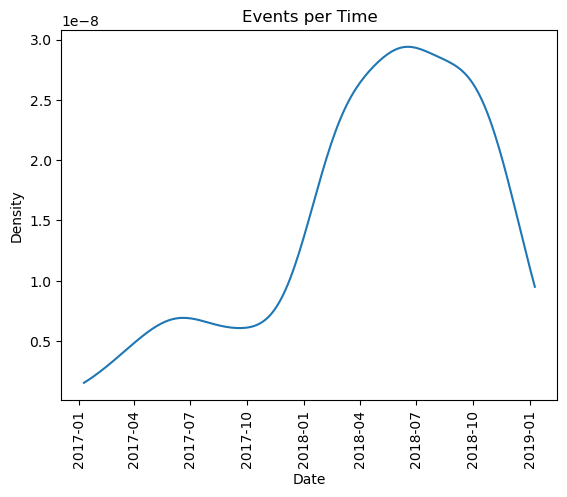

In [82]:
view_events_per_time_graph(log_i)

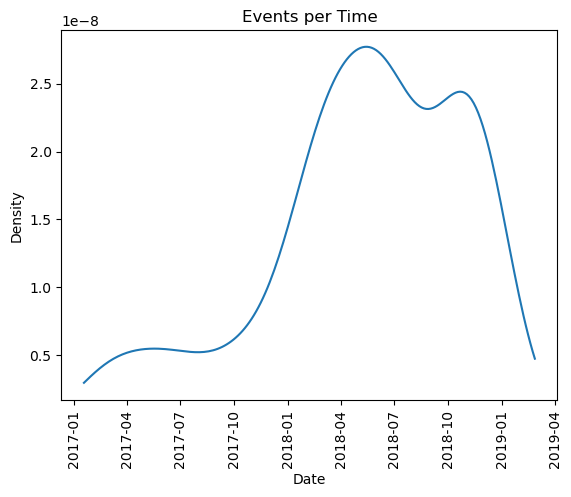

In [83]:
view_events_per_time_graph(log_d)

---
# Process Model(s)

## Top 6 and Top 5 Model (M)

In [84]:
def filter_top_n_variants(log, n):  # Filters and returns df containing the top n variants of a given logfile

    df = log
    variants = pm4py.get_variants(df, activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')
    variants = dict(sorted(variants.items(), key=lambda item: item[1], reverse=True))  # sort dictionary by value in descending order

    top_variants = [list(variants.items())[i] for i in range(n)]
    
    valid_cases_list = []
    for variant in top_variants:
        grouped = df.groupby('case:concept:name')['concept:name'].apply(list)
        valid_cases = grouped[grouped.apply(lambda x: all(item in x for item in variant[0]) and len(x) == len(variant[0]))].index
        valid_cases_list.extend(valid_cases)
    
    filtered_df = df[df['case:concept:name'].isin(valid_cases_list)]

    return filtered_df

In [131]:
log_i_top_8 = filter_top_n_variants(log_i, 8)
log_d_top_5 = filter_top_n_variants(log_d, 5)

## Petri Net or DFG (I)

## Start + End Activities (M)



In [86]:
def return_start_activities(log):
    start_activities = pm4py.get_start_activities(
        log, 
        activity_key='concept:name', 
        case_id_key='case:concept:name', 
        timestamp_key='time:timestamp')
    
    return start_activities

def return_end_activities(log):
    end_activities = pm4py.get_end_activities(
        log, 
        activity_key='concept:name', 
        case_id_key='case:concept:name', 
        timestamp_key='time:timestamp')
    
    return end_activities

In [87]:
print(return_start_activities(log_i))
print(return_start_activities(log_d))

print(return_end_activities(log_i))
print(return_end_activities(log_d))

{'Permit SUBMITTED by EMPLOYEE': 5294, 'Start trip': 740, 'Declaration SUBMITTED by EMPLOYEE': 407, 'Declaration SAVED by EMPLOYEE': 8}
{'Declaration SUBMITTED by EMPLOYEE': 10365, 'Declaration SAVED by EMPLOYEE': 135}
{'Payment Handled': 5646, 'End trip': 593, 'Declaration REJECTED by EMPLOYEE': 130, 'Declaration SAVED by EMPLOYEE': 54, 'Declaration REJECTED by MISSING': 11, 'Permit REJECTED by MISSING': 8, 'Request Payment': 3, 'Send Reminder': 2, 'Declaration FINAL_APPROVED by SUPERVISOR': 1, 'Declaration REJECTED by SUPERVISOR': 1}
{'Payment Handled': 10043, 'Declaration REJECTED by EMPLOYEE': 284, 'Declaration SAVED by EMPLOYEE': 134, 'Declaration REJECTED by MISSING': 30, 'Declaration REJECTED by ADMINISTRATION': 5, 'Declaration REJECTED by SUPERVISOR': 4}


## Fitness (M)

In [132]:
print(len(log_i_top_8['case:concept:name'].unique()))
print(len(log_i['case:concept:name'].unique()))

4101
6449


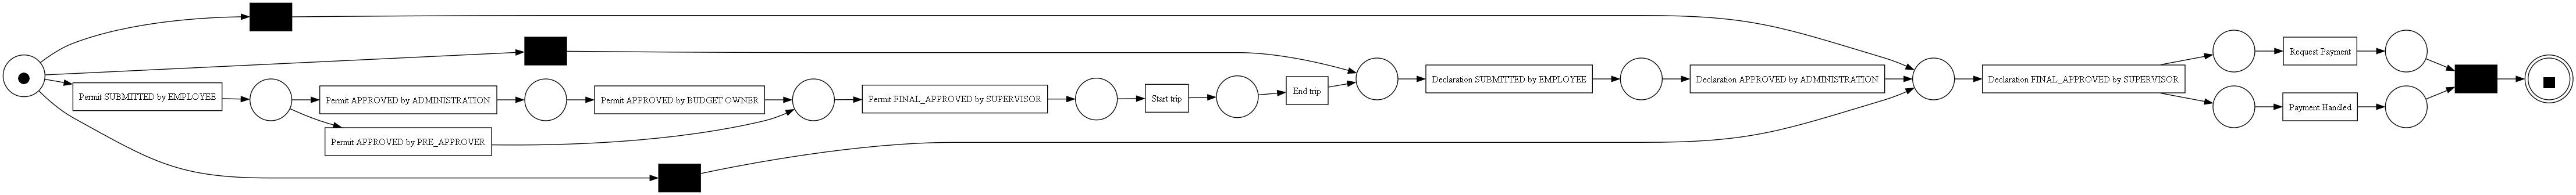

In [133]:
log = log_i_top_8
net, im, fm = pm4py.discover_petri_net_inductive(
    log=log,
    noise_threshold=.8,
    activity_key='concept:name',
    timestamp_key='time:timestamp',
    case_id_key='case:id'
)
pm4py.view_petri_net(net, im, fm)

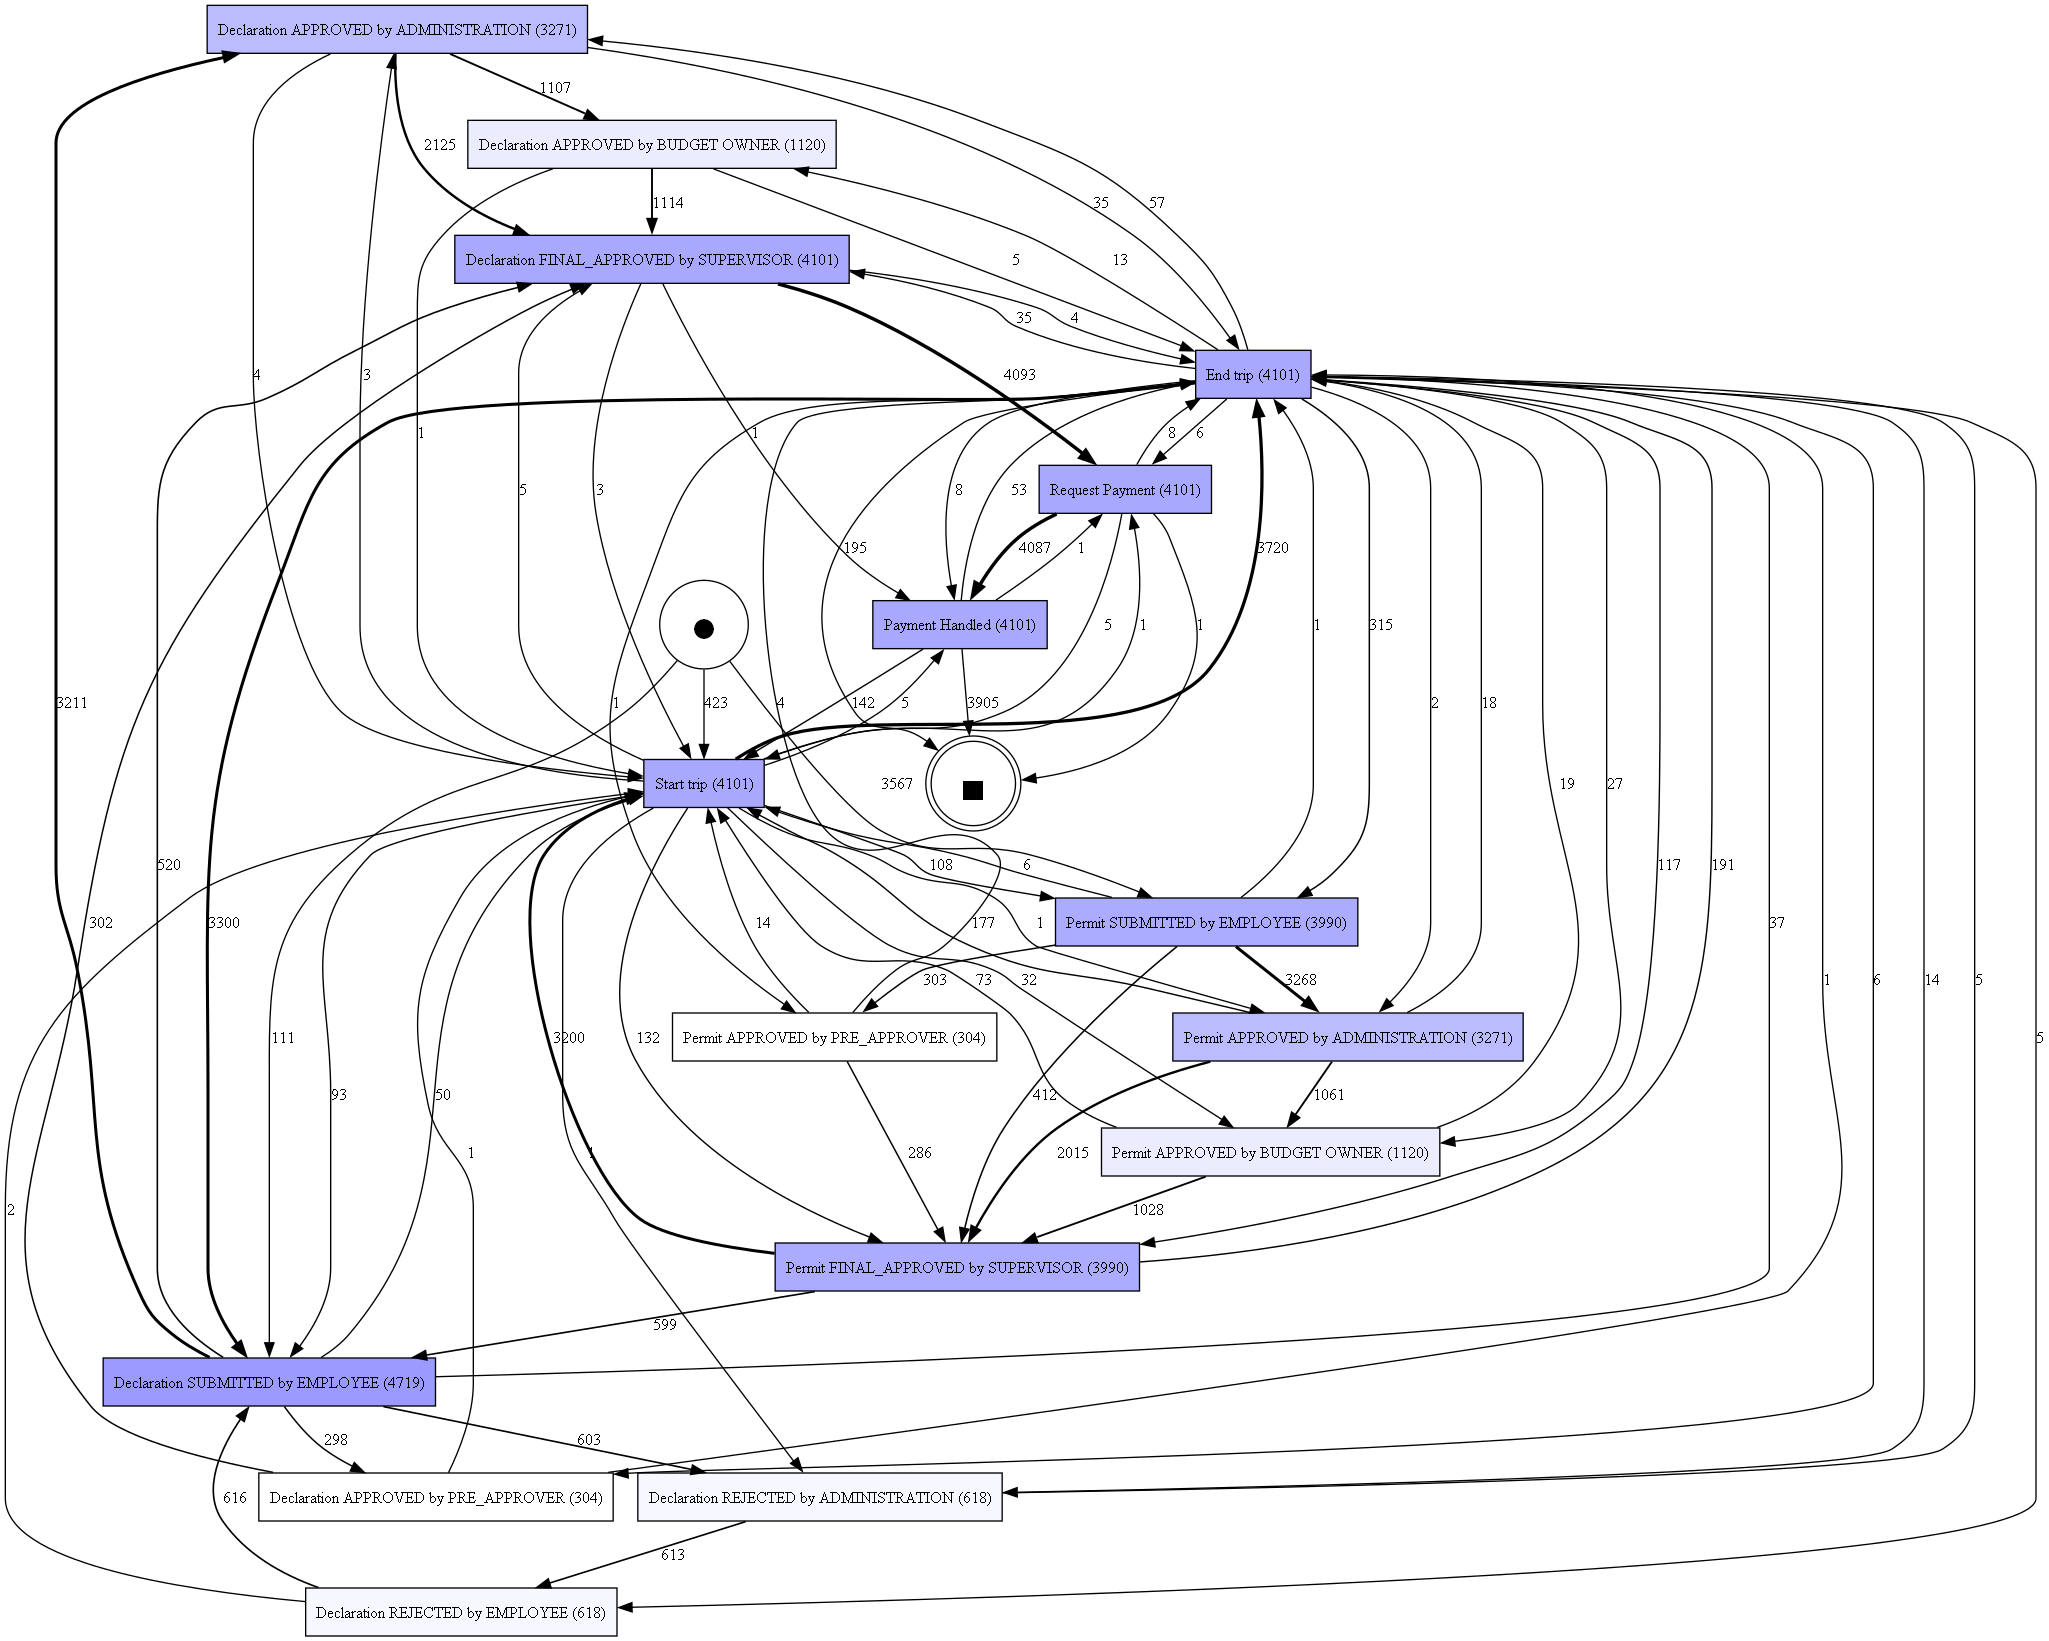

In [134]:
log = log_i_top_8
dfg, sa, ea = pm4py.discover_dfg(
    log,
    activity_key='concept:name',
    timestamp_key='time:timestamp',
    case_id_key='case:id'
)
pm4py.view_dfg(dfg, sa, ea)

In [137]:
log = log_i
net, im, fm = pm4py.discover_petri_net_inductive(log_i_top_8, activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')

fitness_tbr = pm4py.fitness_alignments(log, net, im, fm, activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')
fitness_tbr

aligning log, completed variants ::   0%|          | 0/753 [00:00<?, ?it/s]

{'percFitTraces': 73.67033648627694,
 'averageFitness': 0.9473390597396801,
 'percentage_of_fitting_traces': 73.67033648627694,
 'average_trace_fitness': 0.9473390597396801,
 'log_fitness': 0.9452370995495242}

In [127]:
print(len(log_d_top_5['case:concept:name'].unique()))
print(len(log_d['case:concept:name'].unique()))

9403
10500


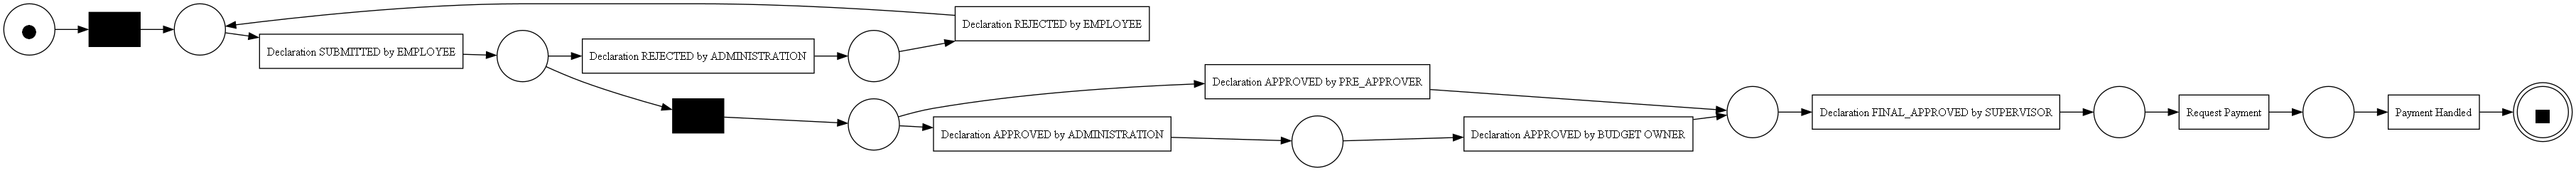

In [136]:
log = log_d_top_5
net, im, fm = pm4py.discover_petri_net_inductive(
    log=log,
    noise_threshold=.8,
    activity_key='concept:name',
    timestamp_key='time:timestamp',
    case_id_key='case:id'
)
pm4py.view_petri_net(net, im, fm)

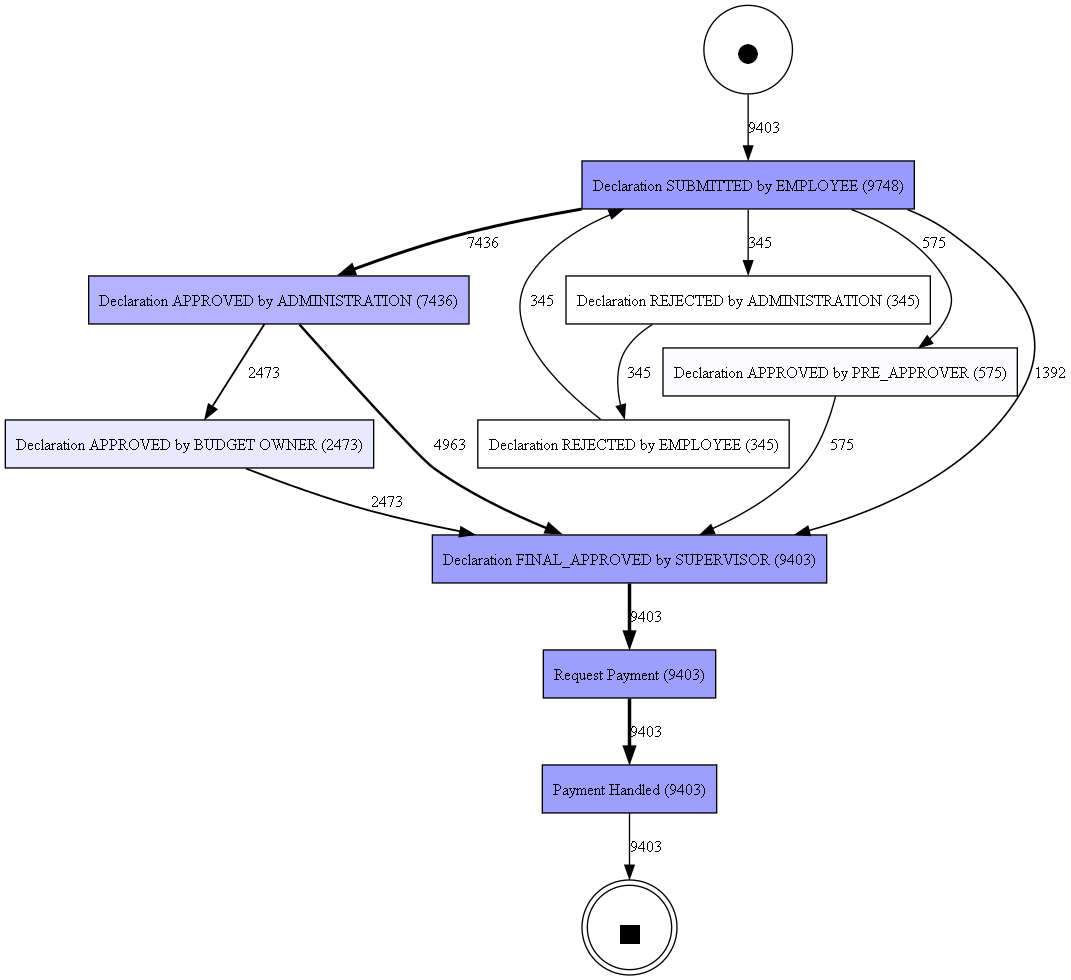

In [120]:
log = log_d_top_5
dfg, sa, ea = pm4py.discover_dfg(
    log,
    activity_key='concept:name',
    timestamp_key='time:timestamp',
    case_id_key='case:id'
)
pm4py.view_dfg(dfg, sa, ea)

In [135]:
log = log_d
net, im, fm = pm4py.discover_petri_net_inductive(log_d_top_5, activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')

fitness_tbr = pm4py.fitness_alignments(log, net, im, fm, activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')
fitness_tbr

aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

{'percFitTraces': 92.00952380952381,
 'averageFitness': 0.9615393640349872,
 'percentage_of_fitting_traces': 92.00952380952381,
 'average_trace_fitness': 0.9615393640349872,
 'log_fitness': 0.9674543059920164}

## Unexpected Behaviour (only one case of...) (M)


## Recycled applications (M)

## Differences between international and domestic application (I)

---
# Specific Questions

## How long do the different process instances take? Are there any notable patterns? (M)
- Average durations of the whole process
- Average duration of each activity
- Total duration of each activity 
> (Put visualization of avg + total durations next to each other)
- Unexpected behaviour: e.g. "Saved by employee" (dom)

### Average durations of the whole process

In [88]:
def avg_duration_of_cases(log):
    case_arr_avg = pm4py.get_case_arrival_average( #Gets the average difference between the start times of two consecutive cases
        log, 
        activity_key='concept:name', 
        case_id_key='case:concept:name', 
        timestamp_key='time:timestamp')
    return case_arr_avg  

In [89]:

duration_i = avg_duration_of_cases(log_i)
duration_d = avg_duration_of_cases(log_d)

print(f"International: {duration_i / 24} hours")
print(f"Domestic: {duration_d / 24} hours")

International: 447.0025136993383 hours
Domestic: 246.65215734831887 hours


The output above shows, that the average duration of the process for international travel is 447 hours. The Domestic Travel process, on the other hand, has a duration of 247 hours. The duration from the beginning to the end of each case was taken into account, based on which an average was calculated.

### Average and Total duration of each activity

Now let's look at the duration by individual activities. These can give us first indications of possible bottlenecks.

To do this, a duration is first calculated for each entry in the logfile and appended as a new column. Here, it is assumed that the duration of an activity is the difference between the current timestamp of one activity and the timestamp of the previous activity. Therefore, the first activity of each case has no duration and gets marked as ``NaT``. However, in order to calculate only the durations within a case per activity, the data set is grouped by Case ID ```('case:concept:name')``` beforehand. We want to make sure that the activities of each case are presented in the correct order, so we sort secondarily by timestamp ```('time:timestamp')```. We have applied this to both datasets. The first 5 lines of each output can be seen as follows:

In [90]:
log_i = log_i.sort_values(['case:concept:name', 'time:timestamp'])
log_i['duration'] = log_i.groupby('case:concept:name')['time:timestamp'].diff()  # difference of one timestamp to next between two activities of one case
log_i['duration'].fillna(pd.Timedelta(seconds=0), inplace=True)
log_i[:5]

,id,org:resource,concept:name,time:timestamp,org:role,case:Permit travel permit number,case:DeclarationNumber,case:Amount,case:RequestedAmount,case:Permit TaskNumber,case:Permit BudgetNumber,case:OriginalAmount,case:Permit ProjectNumber,case:concept:name,case:Permit OrganizationalEntity,case:travel permit number,case:Permit RequestedBudget,case:id,case:Permit ID,case:Permit id,case:BudgetNumber,case:Permit ActivityNumber,case:AdjustedAmount,duration
27174,st_step 1004_0,STAFF MEMBER,Permit SUBMITTED by EMPLOYEE,2018-03-01 09:55:17+00:00,EMPLOYEE,travel permit number 993,declaration number 1003,361.39224,361.39224,UNKNOWN,budget 994,361.39224,UNKNOWN,declaration 1002,organizational unit 65460,travel permit number 993,1273.252058,declaration 1002,travel permit 992,travel permit 992,budget 146827,activity 995,361.39224,0 days 00:00:00
27175,st_step 1005_0,STAFF MEMBER,Permit APPROVED by ADMINISTRATION,2018-03-01 09:55:21+00:00,ADMINISTRATION,travel permit number 993,declaration number 1003,361.39224,361.39224,UNKNOWN,budget 994,361.39224,UNKNOWN,declaration 1002,organizational unit 65460,travel permit number 993,1273.252058,declaration 1002,travel permit 992,travel permit 992,budget 146827,activity 995,361.39224,0 days 00:00:04
27176,st_step 1006_0,STAFF MEMBER,Permit FINAL_APPROVED by SUPERVISOR,2018-03-01 14:01:48+00:00,SUPERVISOR,travel permit number 993,declaration number 1003,361.39224,361.39224,UNKNOWN,budget 994,361.39224,UNKNOWN,declaration 1002,organizational unit 65460,travel permit number 993,1273.252058,declaration 1002,travel permit 992,travel permit 992,budget 146827,activity 995,361.39224,0 days 04:06:27
27177,rv_travel permit 992_6,STAFF MEMBER,Start trip,2018-03-18 23:00:00+00:00,EMPLOYEE,travel permit number 993,declaration number 1003,361.39224,361.39224,UNKNOWN,budget 994,361.39224,UNKNOWN,declaration 1002,organizational unit 65460,travel permit number 993,1273.252058,declaration 1002,travel permit 992,travel permit 992,budget 146827,activity 995,361.39224,17 days 08:58:12
27178,rv_travel permit 992_7,STAFF MEMBER,End trip,2018-03-22 23:00:00+00:00,EMPLOYEE,travel permit number 993,declaration number 1003,361.39224,361.39224,UNKNOWN,budget 994,361.39224,UNKNOWN,declaration 1002,organizational unit 65460,travel permit number 993,1273.252058,declaration 1002,travel permit 992,travel permit 992,budget 146827,activity 995,361.39224,4 days 00:00:00


In [91]:
log_d = log_d.sort_values(['case:concept:name', 'time:timestamp'])
log_d['duration'] = log_d.groupby('case:concept:name')['time:timestamp'].diff()  # difference of one timestamp to next between two activities of one case
log_d['duration'].fillna(pd.Timedelta(seconds=0), inplace=True)
log_d[:5]

,id,org:resource,concept:name,time:timestamp,org:role,case:id,case:concept:name,case:BudgetNumber,case:DeclarationNumber,case:Amount,duration
12788,st_step 100004_0,STAFF MEMBER,Declaration SUBMITTED by EMPLOYEE,2018-01-30 08:20:07+00:00,EMPLOYEE,declaration 100000,declaration 100000,budget 86566,declaration number 100001,600.844121,0 days 00:00:00
12789,st_step 100003_0,STAFF MEMBER,Declaration APPROVED by ADMINISTRATION,2018-02-07 08:58:46+00:00,ADMINISTRATION,declaration 100000,declaration 100000,budget 86566,declaration number 100001,600.844121,8 days 00:38:39
12790,st_step 100002_0,STAFF MEMBER,Declaration FINAL_APPROVED by SUPERVISOR,2018-02-08 09:59:05+00:00,SUPERVISOR,declaration 100000,declaration 100000,budget 86566,declaration number 100001,600.844121,1 days 01:00:19
12791,dd_declaration 100000_19,SYSTEM,Request Payment,2018-02-09 11:42:49+00:00,UNDEFINED,declaration 100000,declaration 100000,budget 86566,declaration number 100001,600.844121,1 days 01:43:44
12792,dd_declaration 100000_20,SYSTEM,Payment Handled,2018-02-12 16:31:20+00:00,UNDEFINED,declaration 100000,declaration 100000,budget 86566,declaration number 100001,600.844121,3 days 04:48:31


Now we can group the data set by activity ```('concept:name')```. Here the average duration is calculated using the ``mean()`` function.

In [92]:
def get_average_duration_per_activity(log):
    average_durations = log.groupby('concept:name')['duration'].mean()
    average_durations = average_durations.sort_values(ascending=False)
    return average_durations

Because we want to take into account not only the average duration, but also the total duration, we use ```sum()``` to sum up the duration per activity in a separate function.

In [93]:
def get_total_duration_per_activity(log):
    
    #log['duration_days'] = log['duration'].dt.days
    log['duration_seconds'] = log['duration'].dt.total_seconds()
    total_seconds_per_activity = log.groupby('concept:name')['duration_seconds'].sum()
    total_durations = pd.to_timedelta(total_seconds_per_activity, unit='s')

    #total_durations = log.groupby('concept:name')['duration'].sum()
    total_durations = total_durations.sort_values(ascending=False)
    log = log.drop('duration_seconds', axis = 1)
    return total_durations

In [94]:
def visualize_durations(log):

    average_durations = get_average_duration_per_activity(log)
    average_durations_hours = average_durations.dt.total_seconds() / 3600 # Conversion to hours

    total_durations = get_total_duration_per_activity(log) 
    total_durations_days  = total_durations.dt.total_seconds() / 86400 # Conversions from seconds to days
    

    plt.figure(figsize=(24, 30))

    plt.subplot(2, 1, 1)

    sns.barplot(x=average_durations_hours.values, y=average_durations_hours.index, palette="viridis")

    plt.ylabel('Activity')
    plt.xlabel('Average Duration (hours)')
    plt.title('Average Duration for Each Activity in Hours')

    for i, value in enumerate(average_durations_hours.values):  # Display values next to the bars
        plt.text(value + 0.01 * value, i + 0.11, f"{value:.2f}", fontsize=14)

    plt.subplot(2, 1, 2)

    sns.barplot(x=total_durations_days.values, y=total_durations_days.index, palette="viridis")

    plt.ylabel('Activity')
    plt.xlabel('Total Duration (days)')
    plt.title('Total Duration for Each Activity in Days')

    for i, value in enumerate(total_durations_days.values):  # Display values next to the bars
        plt.text(value + 0.01 * value, i + 0.11, f"{value:.2f}", fontsize=14)

    plt.show();

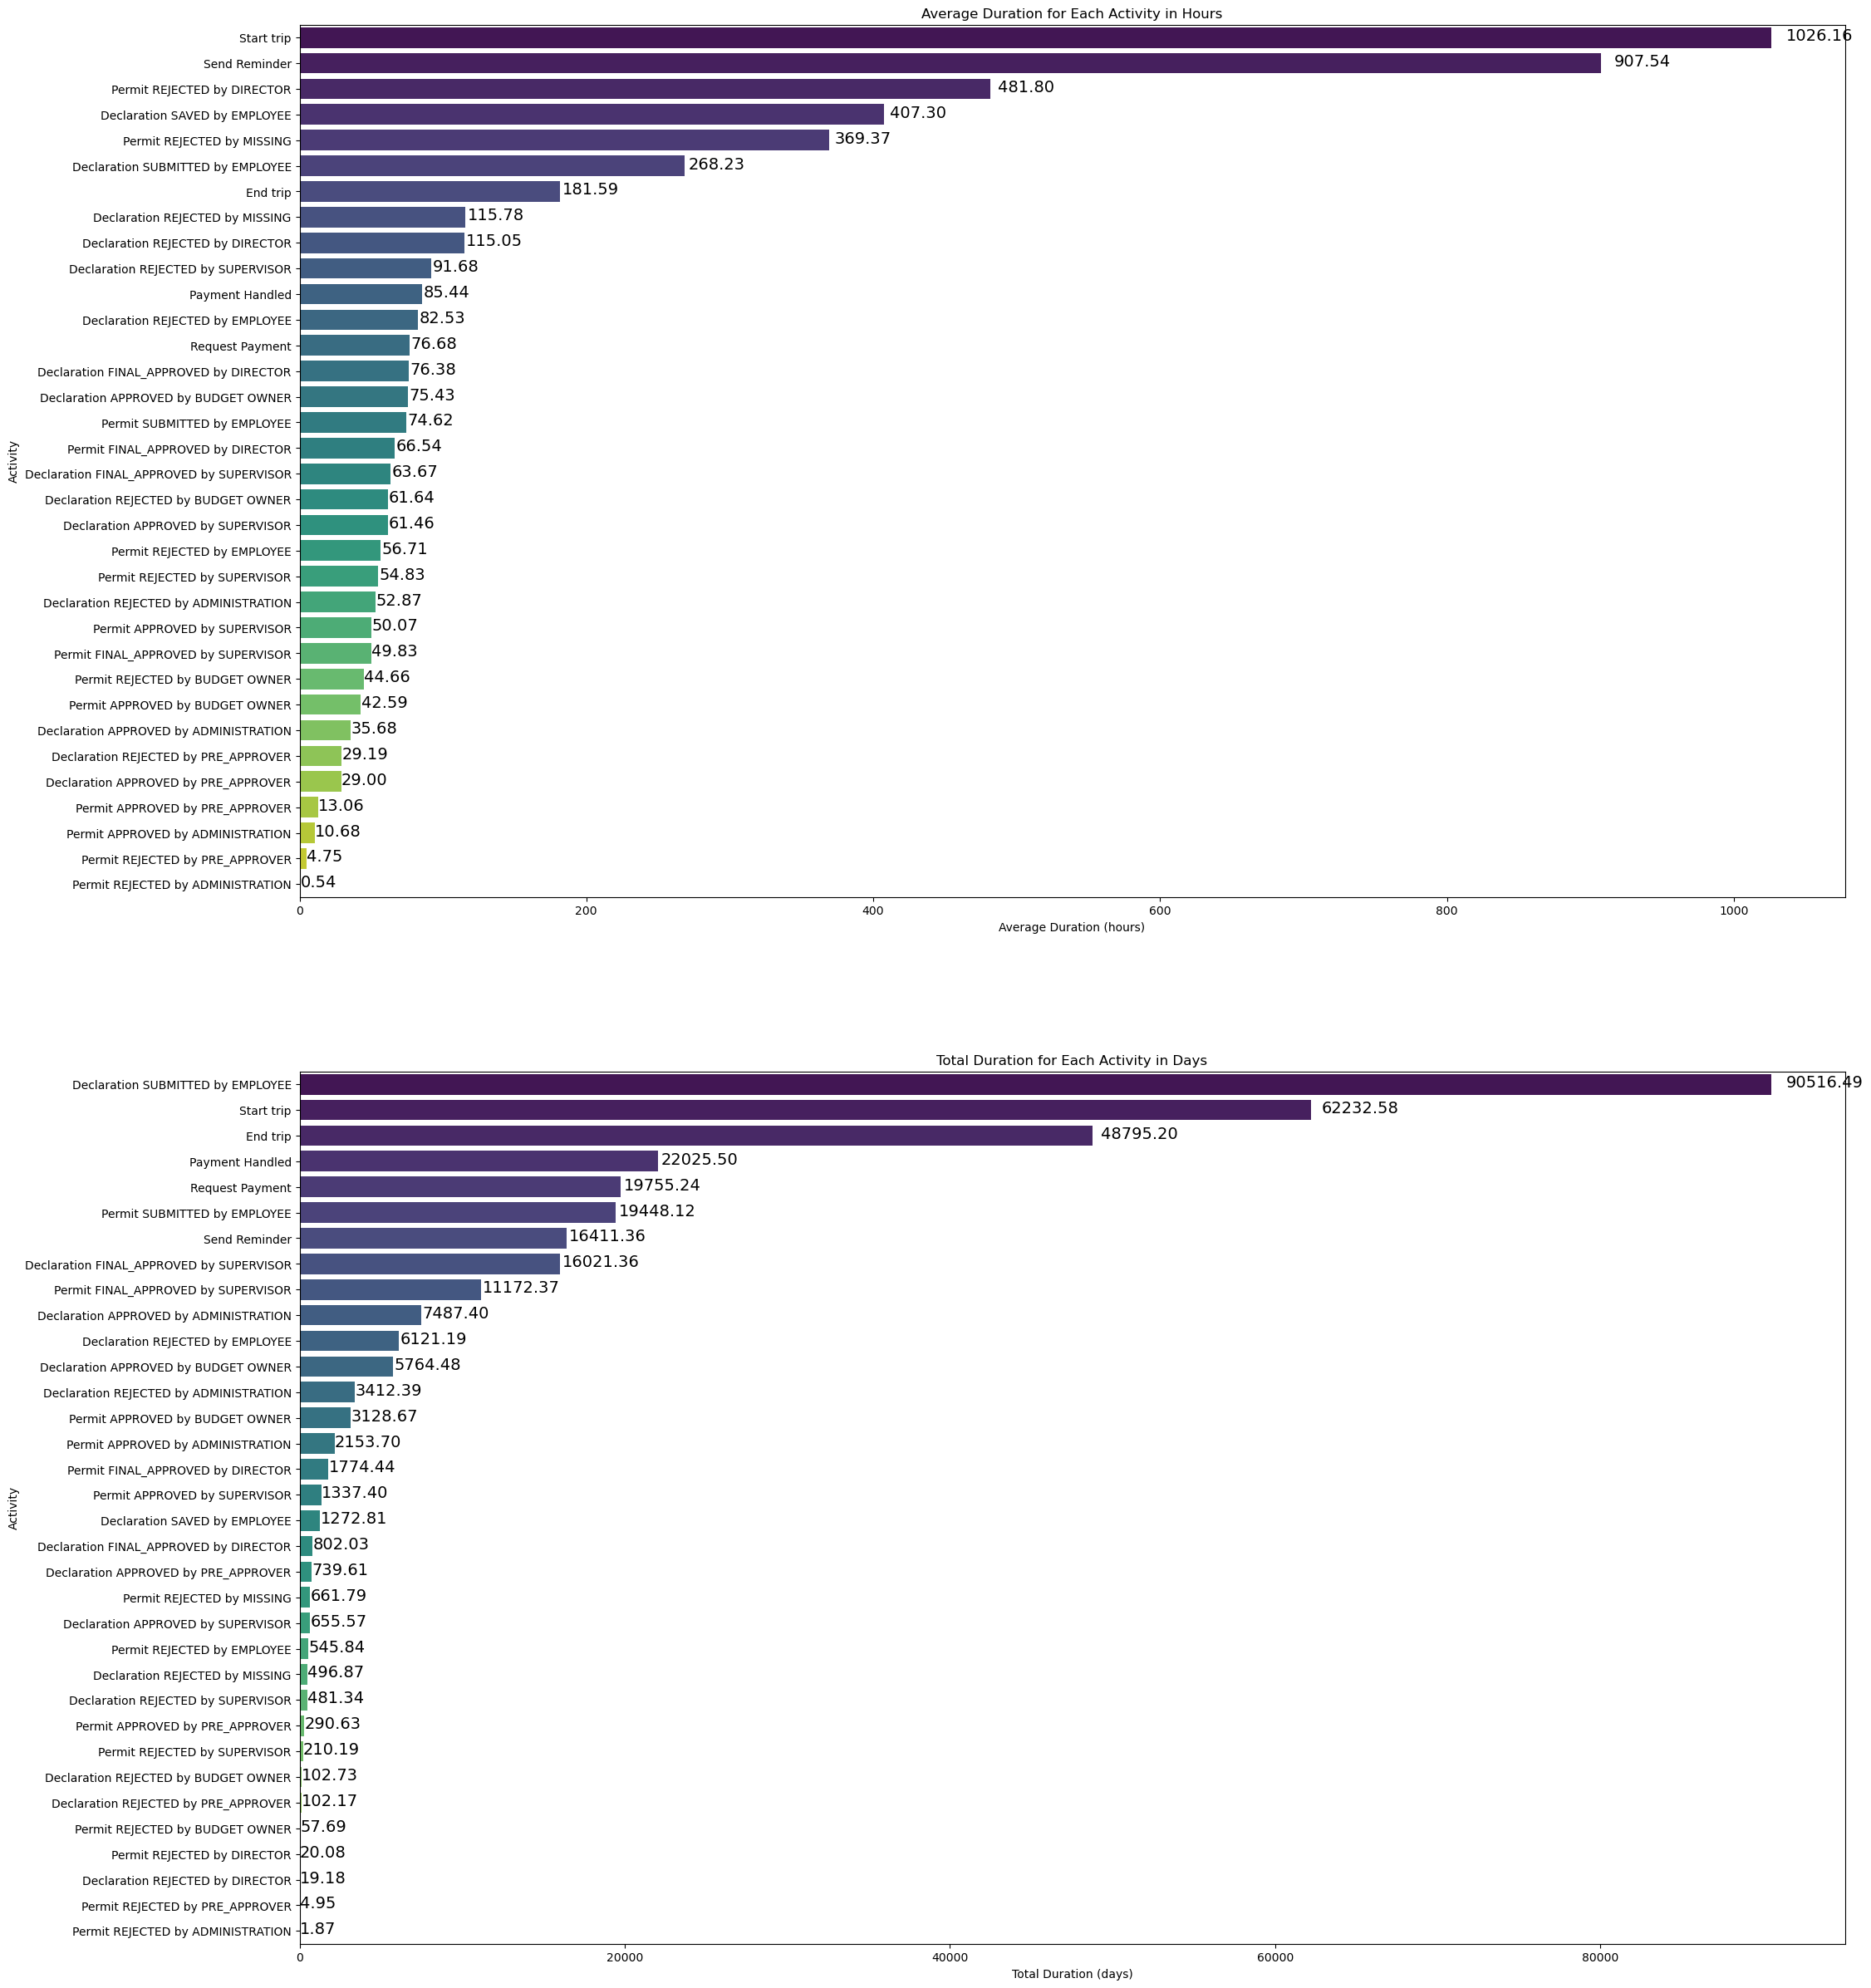

In [95]:
visualize_durations(log_i)

As shown in the graph above, two barplots are shown for the Average Duration for each Activity and the Total duration for each Activity. This one was generated based on the data set ``log_i`` for international travel. The following one was generated accordingly based on the date set ``log_d`` for domestic travel.

When examining average durations, the activity ``'Start trip'`` has a high average duration of about 42.5 days or 1026 hours. This is followed by the ``'Send Reminder'`` activity which averages close to 38 days with about 900 hours. The third position in terms of length is occupied by the ``'Permit REJECTED by DIRECTOR'`` activity, which typically spans around 481 hours or 20 days. These considerable durations indicate areas in the process where tasks might be encountering significant delays.

On the other hand, when we consider the total durations, the activity ```'Declaration SUBMITTED by EMPLOYEE'``` accumulates to 90516 days. This suggests that even though its average duration of 268 hours or 11 days isn't the highest, the activity occurs frequently. The ``'Start trip'`` activity has a total of 62232 days, and the ``'End trip'`` activity accumulates 48795 days.

Furthermore, some activities, like ``'Permit REJECTED by ADMINISTRATION'``, show a relatively short total duration when compared to their average durations, hinting that they might not occur frequently. The varying durations across activities related to approvals and rejections by different entities such as the ``'DIRECTOR'``, ``'SUPERVISOR'``, and ``'ADMINISTRATION'`` might point to inconsistencies in the process or differing priorities among these roles.

One can observe, that activities related to permit approval or rejection by various entities, such as the ``'DIRECTOR'`` or ``'MISSING'``, tend to have longer average durations. This might indicate that the permit approval process is a key area that could benefit from optimization. Moreover, while the Declaration ``'REJECTED by MISSING'`` activity has an average duration of approximately 114 hours or approxemately 5 days , its total duration is 496 days. This suggests that the frequency of such rejections is high, potentially pointing to issues with data or information quality. On the flip side, activities like ``'Permit REJECTED by ADMINISTRATION'`` and ``'Permit REJECTED by PRE_APPROVER'`` exhibit shorter average durations, hinting at a swifter rejection process in these scenarios.

Moreover, while activities like Declaration ``'SAVED by EMPLOYEE'`` and ``'Permit REJECTED by MISSING'`` might individually take time, they don't seem to occur as frequently as others, given their absence from the top total durations. Lastly, there's a noticeable variation in the durations for activities related to ``'Permit'``. For example, ``'Permit REJECTED by DIRECTOR'``  averages 481 hours, while ``'Permit REJECTED by PRE_APPROVER'`` averages just about 4.75 hours.

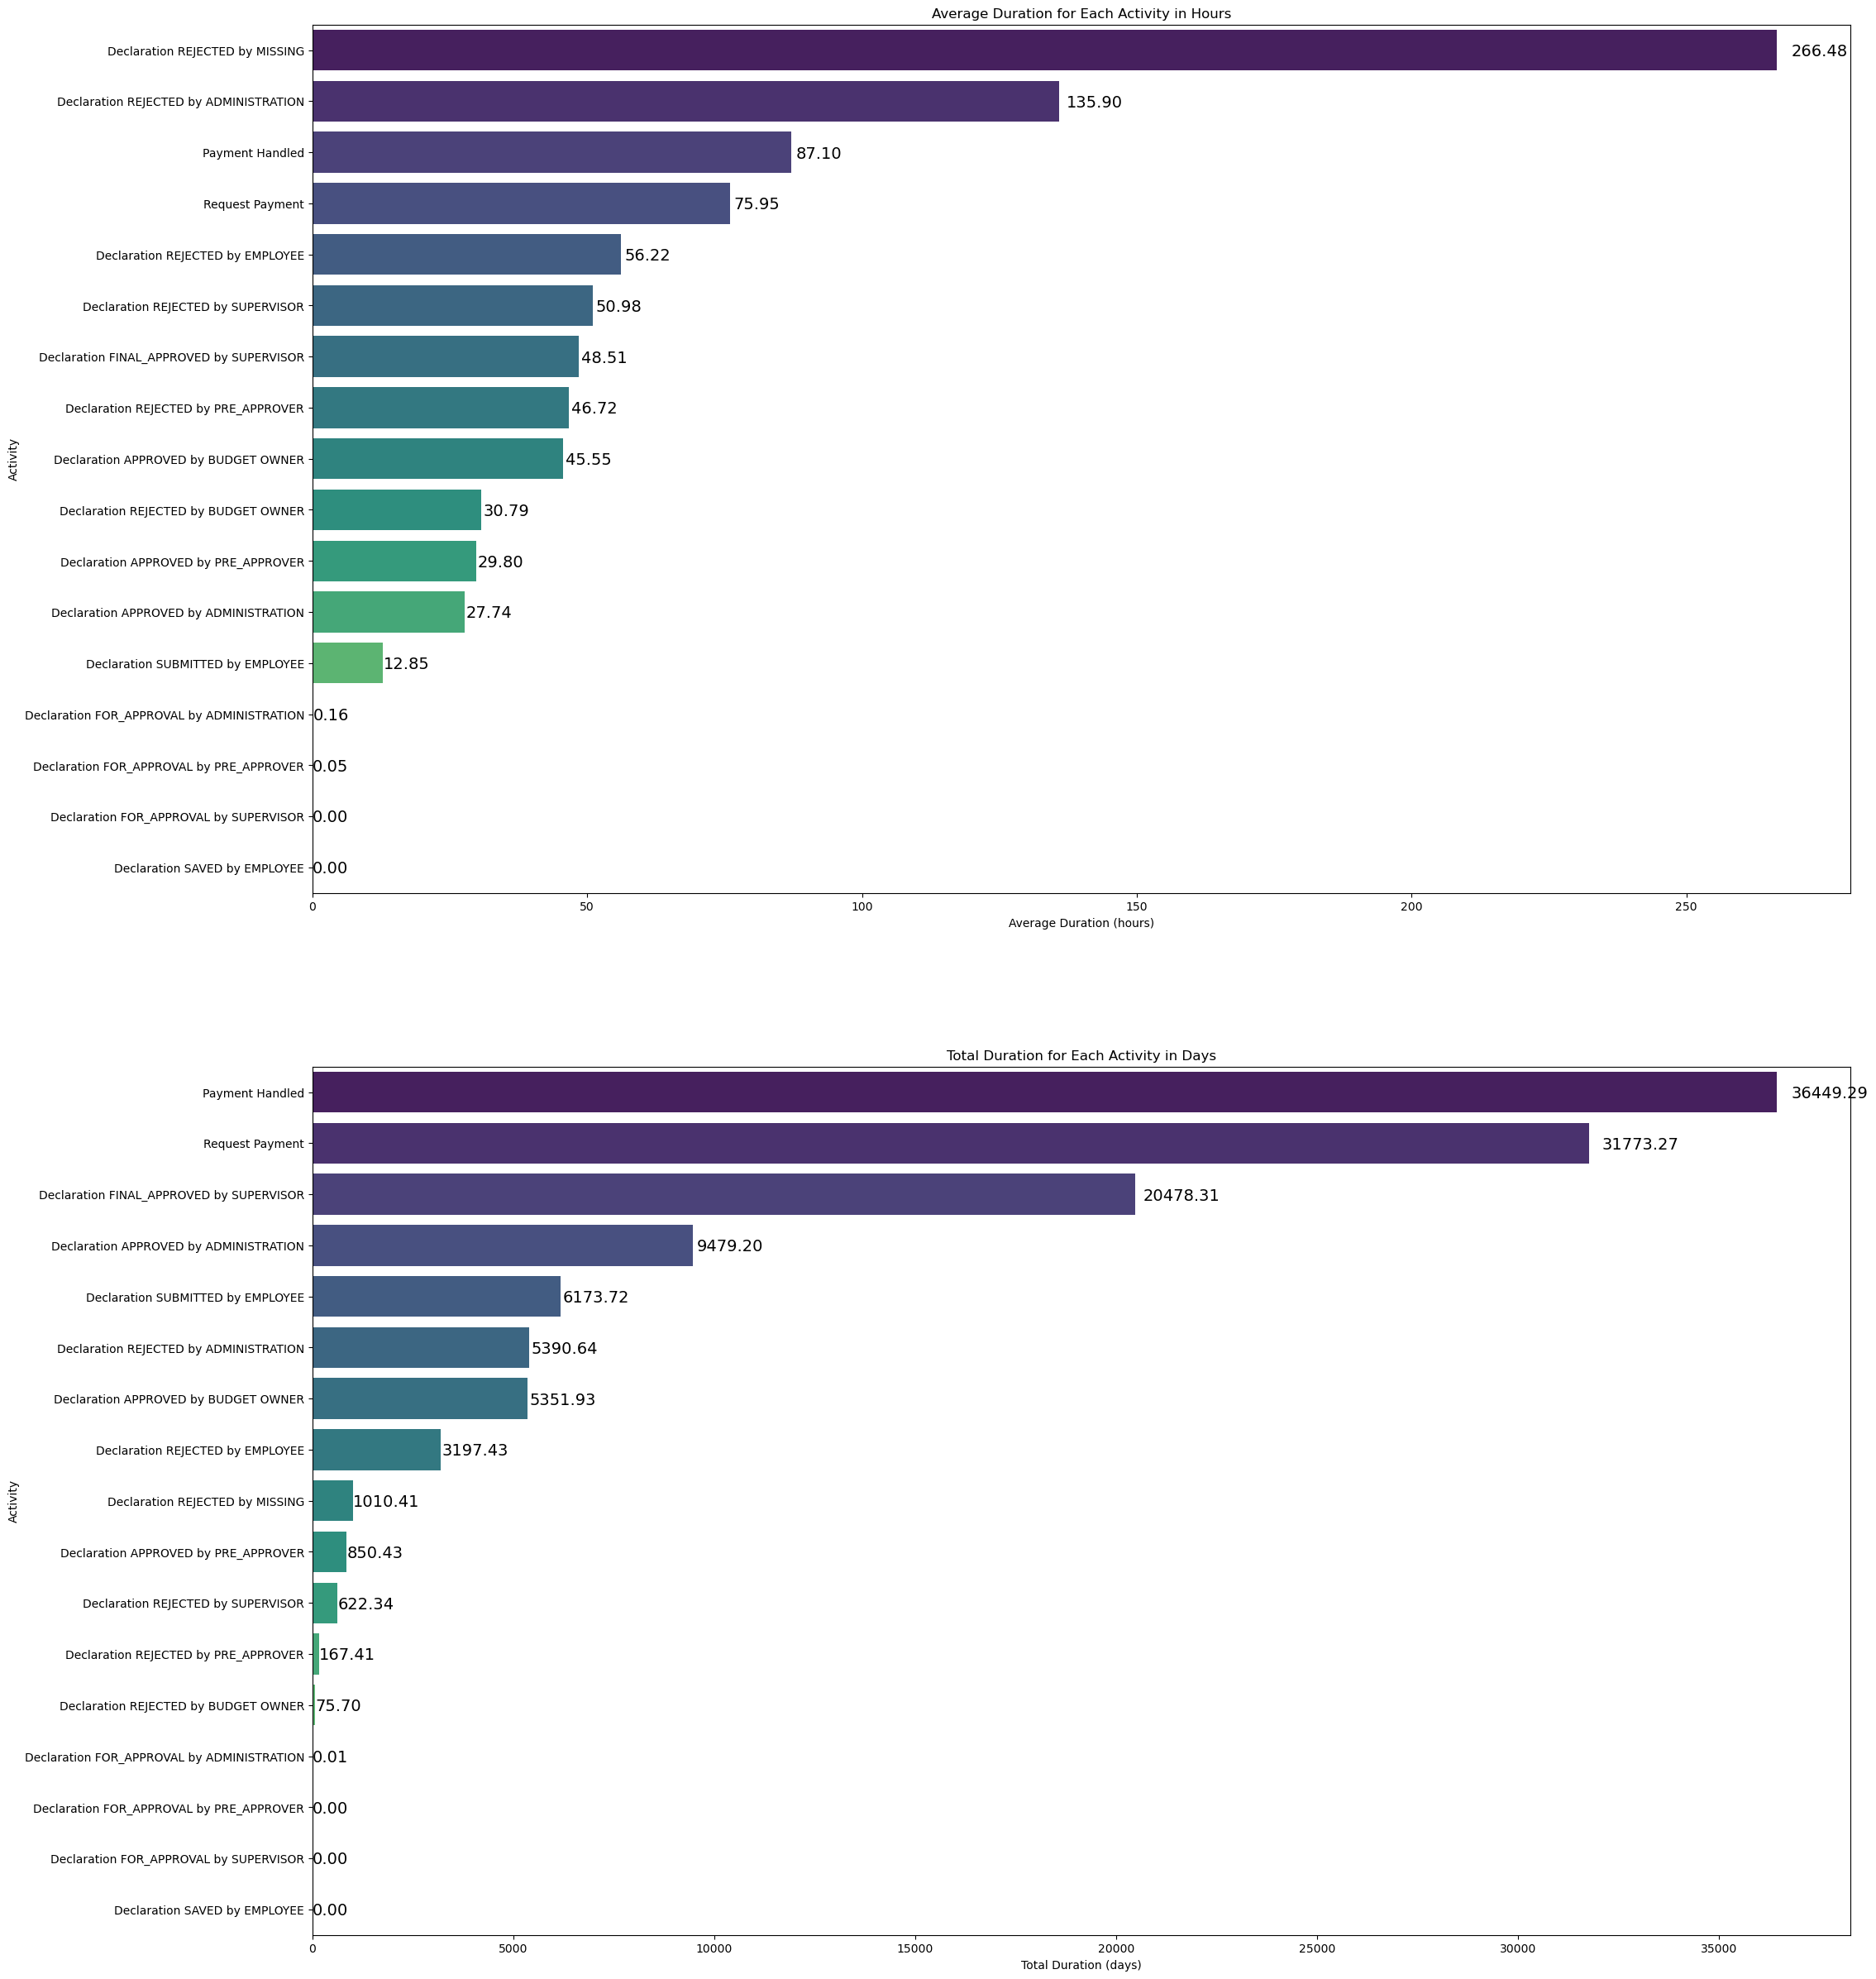

In [96]:
visualize_durations(log_d)

The activity with the longest average duration is ``'Declaration REJECTED by MISSING'``, which takes an average of 266 hours or approximately 11 days. This duration suggests a significant delay when items are rejected by an here unknown role. The next activity with a long average duration is ``'REJECTED by ADMINISTRATION'``, taking with 135 hours about 5 days and 16 hours, indicating another potential area of inefficiency. The activity ``'Payment Handled'`` has an average duration of approximately 3.5 days. Given that this is a crucial step in most processes, it's worth investigating why it takes such a long time.

A glance at the chart for total duration offers new insights. The most time consuming activities are the those handled by the resource ``'SYSTEM'``, which are ``'Request Payment'`` and ``'Payment Handled'``.  The latter is at the top with a total of 36449 days, making it the most time-consuming activity overall. The activity ``'FINAL_APPROVED by SUPERVISOR'`` has a total duration of 20478 days, suggesting that while its average duration isn't the longest, it occurs frequently and thus accumulates significant time. Request Payment is also notable with a total duration of 31773 days. As the starting activity of most cases the value for ``'SUBMITTED by EMPLOYEE'`` usually should be ``NaT`` or ``0``. But in this diagramm the total duration for ``'SUBMITTED by EMPLOYEE'`` represents the durations of those recycled declrations coming back from rejected declarations. 

Another interesting observation is that activities like ``'FOR_APPROVAL by ADMINISTRATION'``, ``'FOR_APPROVAL by PRE_APPROVER'``, and ``'FOR_APPROVAL by SUPERVISOR'`` have very short average durations, implying that the initial approval process is quick. However, the subsequent approval or rejection might be causing delays. 

## Are there any bottlenecks? If yes, where? If yes, can you think of any reasons? (M)

Now that we have an impression of which activities are noteworthy due to their average or total duration, we will uncover between which successive activities the bottlenecks appear in detail. This can best be done by visualising the process landscape.

- dfg graph with durations
- insights from dfg
- insight from diso

In [97]:
log_skeleton = pm4py.discover_log_skeleton(log_d, noise_threshold=0.1, activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')
print(log_skeleton['equivalence'])

{('Declaration APPROVED by PRE_APPROVER', 'Payment Handled'), ('Declaration FOR_APPROVAL by ADMINISTRATION', 'Declaration REJECTED by SUPERVISOR'), ('Request Payment', 'Payment Handled'), ('Declaration FOR_APPROVAL by ADMINISTRATION', 'Request Payment'), ('Declaration APPROVED by BUDGET OWNER', 'Request Payment'), ('Declaration APPROVED by ADMINISTRATION', 'Declaration FINAL_APPROVED by SUPERVISOR'), ('Declaration APPROVED by PRE_APPROVER', 'Declaration FINAL_APPROVED by SUPERVISOR'), ('Declaration FOR_APPROVAL by PRE_APPROVER', 'Declaration SUBMITTED by EMPLOYEE'), ('Declaration APPROVED by ADMINISTRATION', 'Declaration SUBMITTED by EMPLOYEE'), ('Declaration FINAL_APPROVED by SUPERVISOR', 'Payment Handled'), ('Request Payment', 'Declaration FINAL_APPROVED by SUPERVISOR'), ('Request Payment', 'Declaration SUBMITTED by EMPLOYEE'), ('Declaration FOR_APPROVAL by ADMINISTRATION', 'Declaration REJECTED by ADMINISTRATION'), ('Declaration FOR_APPROVAL by PRE_APPROVER', 'Declaration REJECTED b

In [98]:
def show_duration_dfg(log):
    filtered_log = pm4py.filter_case_performance(  # log needs further filtering for adequate representation
        log, 
        0, # min (1 min)
        1728000.0, #max (20d) in seconds
        timestamp_key='time:timestamp', 
        case_id_key='case:concept:name')  
        
    #filtered_log = pm4py.filter_paths_performance(log, ('SUBMITTED by EMPLOYEE', 'Request Payment'), 0, 86400.0, activity_key='concept:name', timestamp_key='time:timestamp', case_id_key='case:concept:name')

    performance_dfg, start_activities, end_activities = pm4py.discover_performance_dfg(
        filtered_log, 
        case_id_key='case:concept:name', 
        activity_key='concept:name', 
        timestamp_key='time:timestamp')

    pm4py.view_performance_dfg(
        performance_dfg, 
        start_activities, 
        end_activities, 
        format='png')

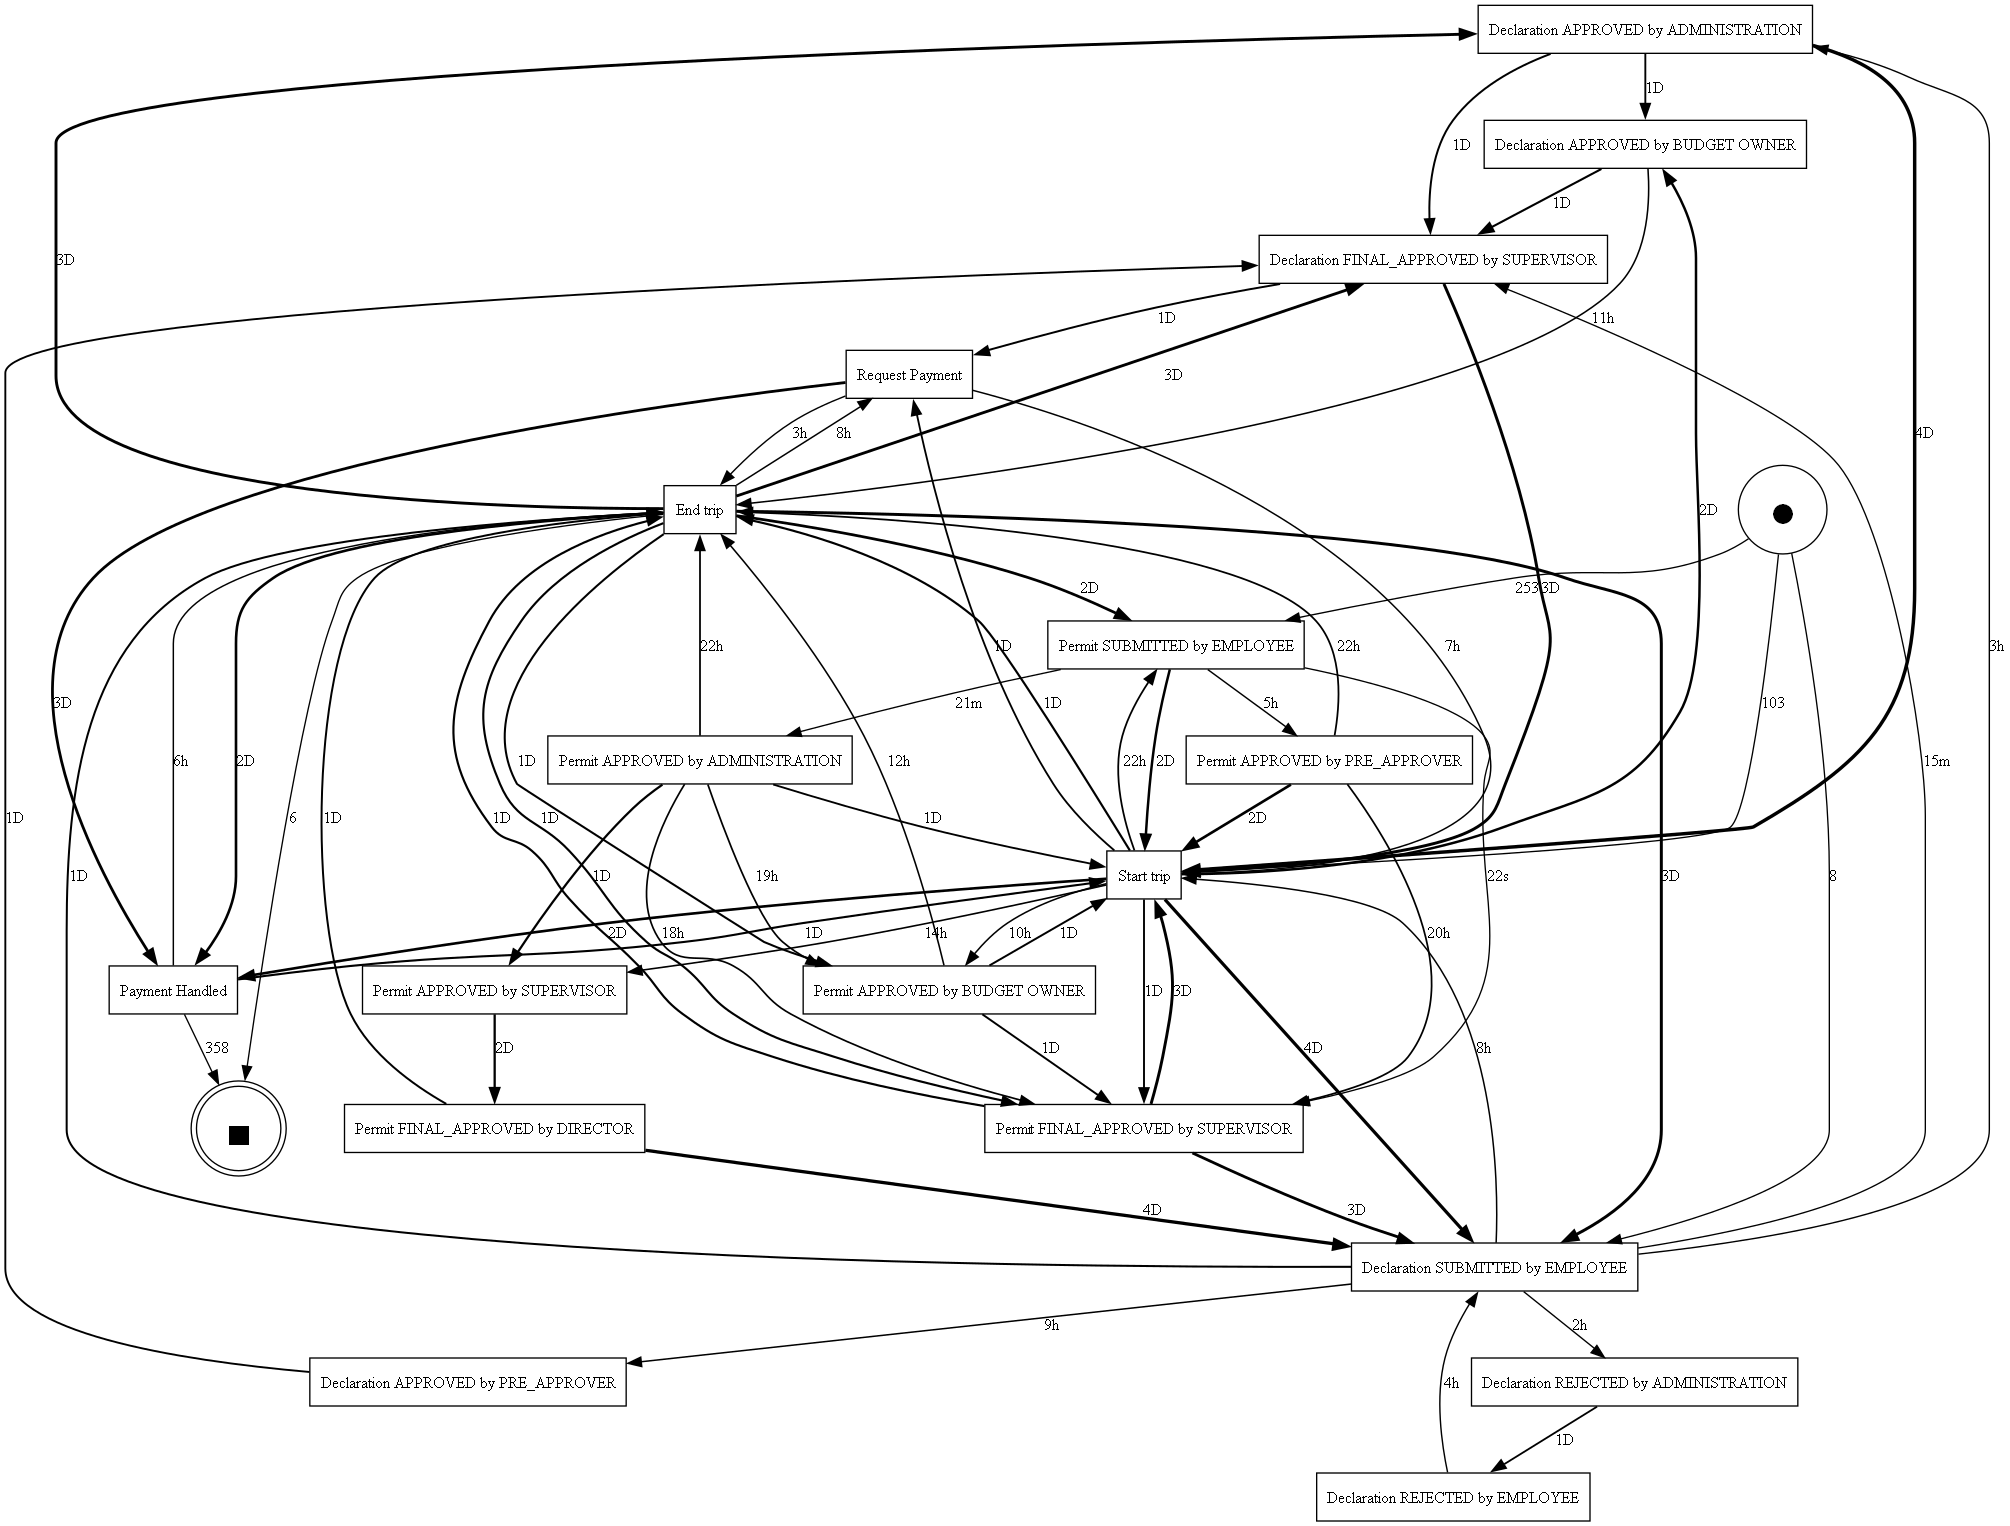

In [99]:
log_i_t15 = filter_top_n_variants(log_i, 15)
show_duration_dfg(log_i_t15)

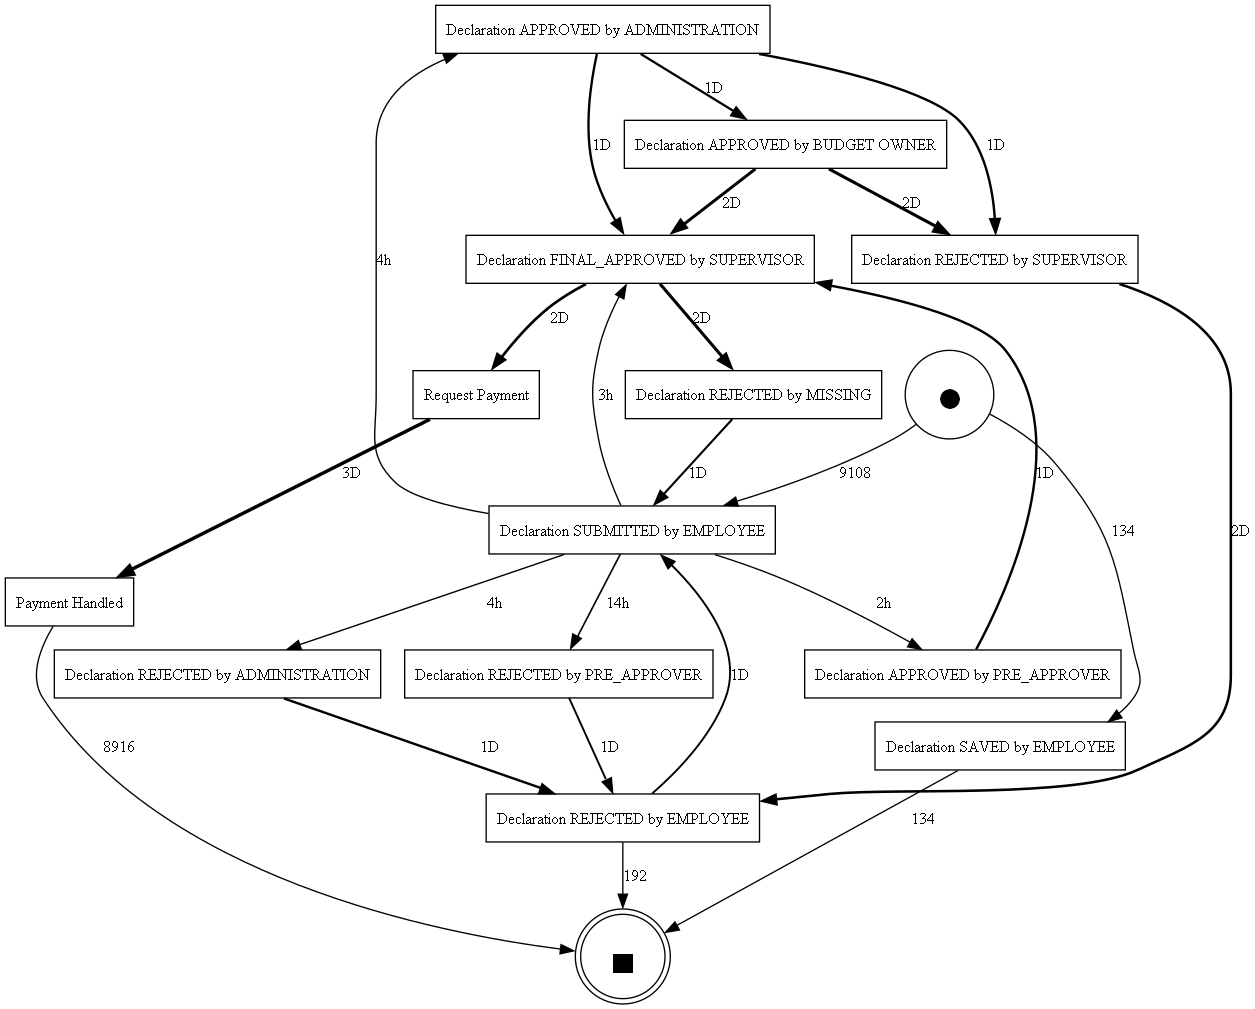

In [100]:
log_d_t15 = filter_top_n_variants(log_d, 15)
show_duration_dfg(log_d_t15)

In [101]:
def filter_duration_by_actvity(log, activity_1, activity_2):

    log = log.sort_values(by=['case:concept:name', 'time:timestamp'])

    log['previous_activity'] = log.groupby('case:concept:name')['concept:name'].shift(1)

    # Filtern Sie die Zeilen heraus, in denen die beiden Aktivitäten aufeinander folgen
    log = log[(log['concept:name'] == activity_1) & (log['previous_activity'] == activity_2)]

    log['duration_seconds'] = log['duration'].dt.total_seconds()
    total_seconds_per_activity = log.groupby('concept:name')['duration_seconds'].sum()
    total_durations = pd.to_timedelta(total_seconds_per_activity, unit='s')

    total_durations = total_durations.sort_values(ascending=False)
    
    total_durations_days = total_durations.dt.total_seconds() / 86400
    log = log.drop('duration_seconds', axis = 1)
    log = log.drop('previous_activity', axis = 1)

    return total_durations_days




In [102]:
df = log_d_t15
activity_1 = 'Payment Handled'
activity_2 = 'Request Payment'

df = df.sort_values(by=['case:concept:name', 'time:timestamp'])

df['previous_activity'] = df.groupby('case:concept:name')['concept:name'].shift(1)

filtered_df = df[(df['concept:name'] == activity_1) & (df['previous_activity'] == activity_2)]

print(get_total_duration_per_activity(filtered_df))


concept:name
Payment Handled   35336 days 21:13:41
Name: duration_seconds, dtype: timedelta64[ns]


Obvious bottlenecks:
- Request Payment -> Payment Handled (System)

DISCO (Map -> Performance Total Duration): 
- "FINAL_APPROVED by SUPERVISOR" -> Request Payment (87yrs total)
- "Request Payment" -> "Payment Handled" (98,3 yrs total)
- "APPROVED by ADMINISTRATION" -> "FINAL_APPROVED by SUPERVISOR"
- "APPROVED by BUDGET OWNER" -> "FINAL_APPROVED by SUPERVISOR"

Additional remarks (from DISCO):
- only one case with "For_APPROVAL by SUPERVISOR" -> "REJECTED by MISSING"
- only one case with "SAVED by EMPLOYEE" -> "Request Payment"
- only one case with "For_APPROVAL by PRE_APPROVER" -> "REJECTED by MISSING"
- only one case with "For_APPROVAL by SUPERVISOR" -> "REJECTED by MISSING"
- only one case with "FOR_APPROVAL by ADMINISTRATION"
- 1081 declarations are getting recycled

## How many applications get rejected? Can you find any reasons? (M)
- amount of rejection total
- amount of rejections based on role
- boxplot rejquested amount of rejected delcarations by role
- boxplot rejquested amount of approved delcarations by role
- Distribution of requested amount of rejected vs approved cases

### Amount of rejections
First we take a look at the total total amount of rejections. Here we filter those activities containing ``'REJECTED'``. The filtered data set cotains now rejections by certain role and ```'REJECTED by EMPLOYEE'```. However, most rejections of a certain role lead to the activity ``'REJECTED by EMPLOYEE'``. Therefore, it is sufficient for the time being to filter for all activities that contain ``'REJECTED by EMPLOYEE'``. The output of the amount of rejected application of each data set can be seen below.

In [103]:

log_i_r = log_i[log_i["concept:name"].str.contains('REJECTED by EMPLOYEE')]  # Includes Rejections of Permits
log_d_r = log_d[log_d["concept:name"].str.contains('REJECTED by EMPLOYEE')]


len_log_i_r = len(log_i_r)
len_log_d_r = len(log_d_r)
len_unique_case_i = len(log_i['case:concept:name'].unique())
len_unique_case_d = len(log_d['case:concept:name'].unique())


print(f"Amount of rejected applications for international travel: {len_log_i_r}")
print(f"Amount of rejected applications for domestic travel: {len_log_d_r}")
print("-"*75)
print(f"Amount of unique cases for international travel: {len_unique_case_i}")
print(f"Amount of unique cases for domestic travel: {len_unique_case_d}")
print("-"*75)
print(f"Rejection rate for for international travel: {(len_log_i_r/len_unique_case_i)*100}%")
print(f"Rejection rate for for domestic travel: {(len_log_d_r/len_unique_case_d)*100}%")

Amount of rejected applications for international travel: 2011
Amount of rejected applications for domestic travel: 1365
---------------------------------------------------------------------------
Amount of unique cases for international travel: 6449
Amount of unique cases for domestic travel: 10500
---------------------------------------------------------------------------
Rejection rate for for international travel: 31.183129167312764%
Rejection rate for for domestic travel: 13.0%


On the one hand, for international travel, there were a total of ``2011`` applications that did not receive approval. The data set for international travel has ``6449`` unique cases. From this pool, the rejection rate was about ``31.18%``, indicating that nearly one-third of the individuals who sought to travel internationally encountered rejection.

On the other hand, for domestic travel, ``1365`` applications were not approved. In contast to international travel the unique cases for domestic travel, amounts to ``10500``. This could be a sign of a greater demand or inclination to travel within the country. Even with the larger number of unique cases, the rejection rate for domestic travel was significantly lower than its international counterpart, standing at ``13%``.

The contrasting rejection rates could be due to more stringent regulations associated with international travel, the intricacies of documentation requirements, or the sheer volume of applicants.

### Amount of rejections based on role

In [104]:
def visualize_amount_of_rejections_by_role(log_r):

    ax = sns.countplot(x='org:role', data=log_r, palette='viridis')
    ax.set(title='Amount of Rejections by Role', xlabel='', ylabel='')
    plt.xticks(rotation=45, ha='right')

    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='baseline')  # centering text

In [105]:
log_i_r = log_i[log_i["concept:name"].str.contains('REJECTED')]  # Contains all activities with "REJECTED" in its name, including "REJECTED by EMPLOYEE"
log_d_r = log_d[log_d["concept:name"].str.contains('REJECTED')]

log_i_r = log_i_r[log_i_r['org:role'] != 'EMPLOYEE']   # Filtering out the EMPLOYEE role because most rejected declartions by a certain role are getting followed up by the activity "REJECTED by EMPLOYEE"
log_d_r = log_d_r[log_d_r['org:role'] != 'EMPLOYEE'] 

First, we fillter out all activities with `'REJECTED'` in its name, including ``'REJECTED by EMPLOYEE'``. After that, we filter out the ``'EMPLOYEE'`` role because most rejected applications by a certain role are getting followed up by the activity ``'REJECTED by EMPLOYEE'``.

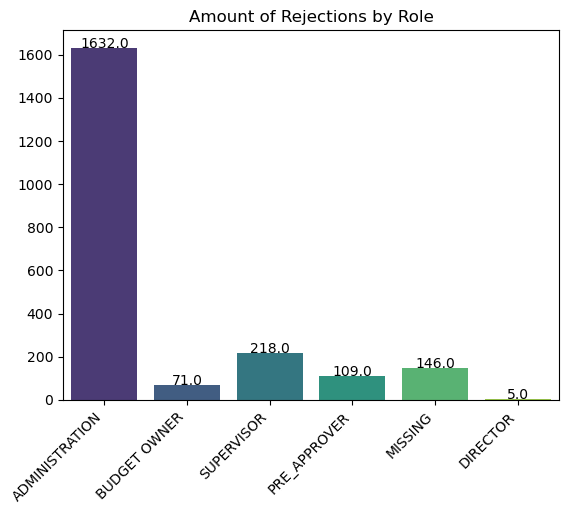

In [106]:
visualize_amount_of_rejections_by_role(log_i_r)

First we take a look at the amount of rejections by role for the dataset for international travel.
As seen in the barchart above, the role ``'ADMINISTRATION'`` is by far responsible for most rejections amounting to 1632. The ``'SUPERVISOR'`` role records the second highest amount of rejections with only 218. This could be another indication of the more stringent regulation of international travel.

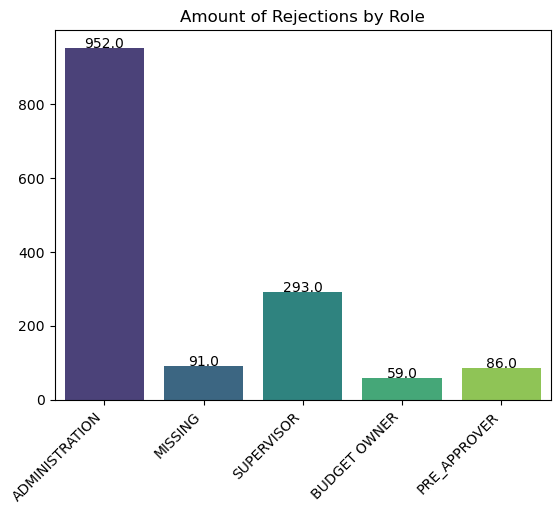

In [107]:
visualize_amount_of_rejections_by_role(log_d_r)

Similar to the international travel dataset, ``'ADMINISTRATION'`` is responsible for most of the rejections for domestic travel.

Now it would be interesting to investigate whether there are indications of the reasons for a rejection in the data set. First we look at the amount requested as an indicator for rejections by role to to reveal possible responsibilities depending on the requested amount. To do this, we first compare all applications that were accepted with those that were rejected.

In [108]:
log_i_a = log_i[log_i['concept:name'].str.contains('APPROVED|FINAL_APPROVED', regex=True)] 
log_d_a = log_d[log_d['concept:name'].str.contains('APPROVED|FINAL_APPROVED', regex=True)] 

In [109]:

def show_boxplot_of_requested_amount_by_role(log_r, log_a):

    plt.figure(figsize=(24, 12))

    plt.subplot(2, 1, 1)
    sns.boxplot(x='case:Amount', y='org:role', data=log_r, palette='viridis').set(title='Boxplot of Requested Amounts of REJECTED Applications by Role', xlabel='', ylabel='')
    plt.xticks(rotation=45, ha='center',ticks=range(0, int(log_r['case:Amount'].max()) + 250, 250)) 
    plt.grid(True)

    plt.subplot(2, 1, 2)
    sns.boxplot(x='case:Amount', y='org:role', data=log_a, palette='viridis').set(title='Boxplot of Requested Amounts of APPROVED Applications by Role', xlabel='', ylabel='')
    plt.xticks(rotation=45, ha='center',ticks=range(0, int(log_a['case:Amount'].max()) + 250, 250)) 
    plt.grid(True)

    plt.show()

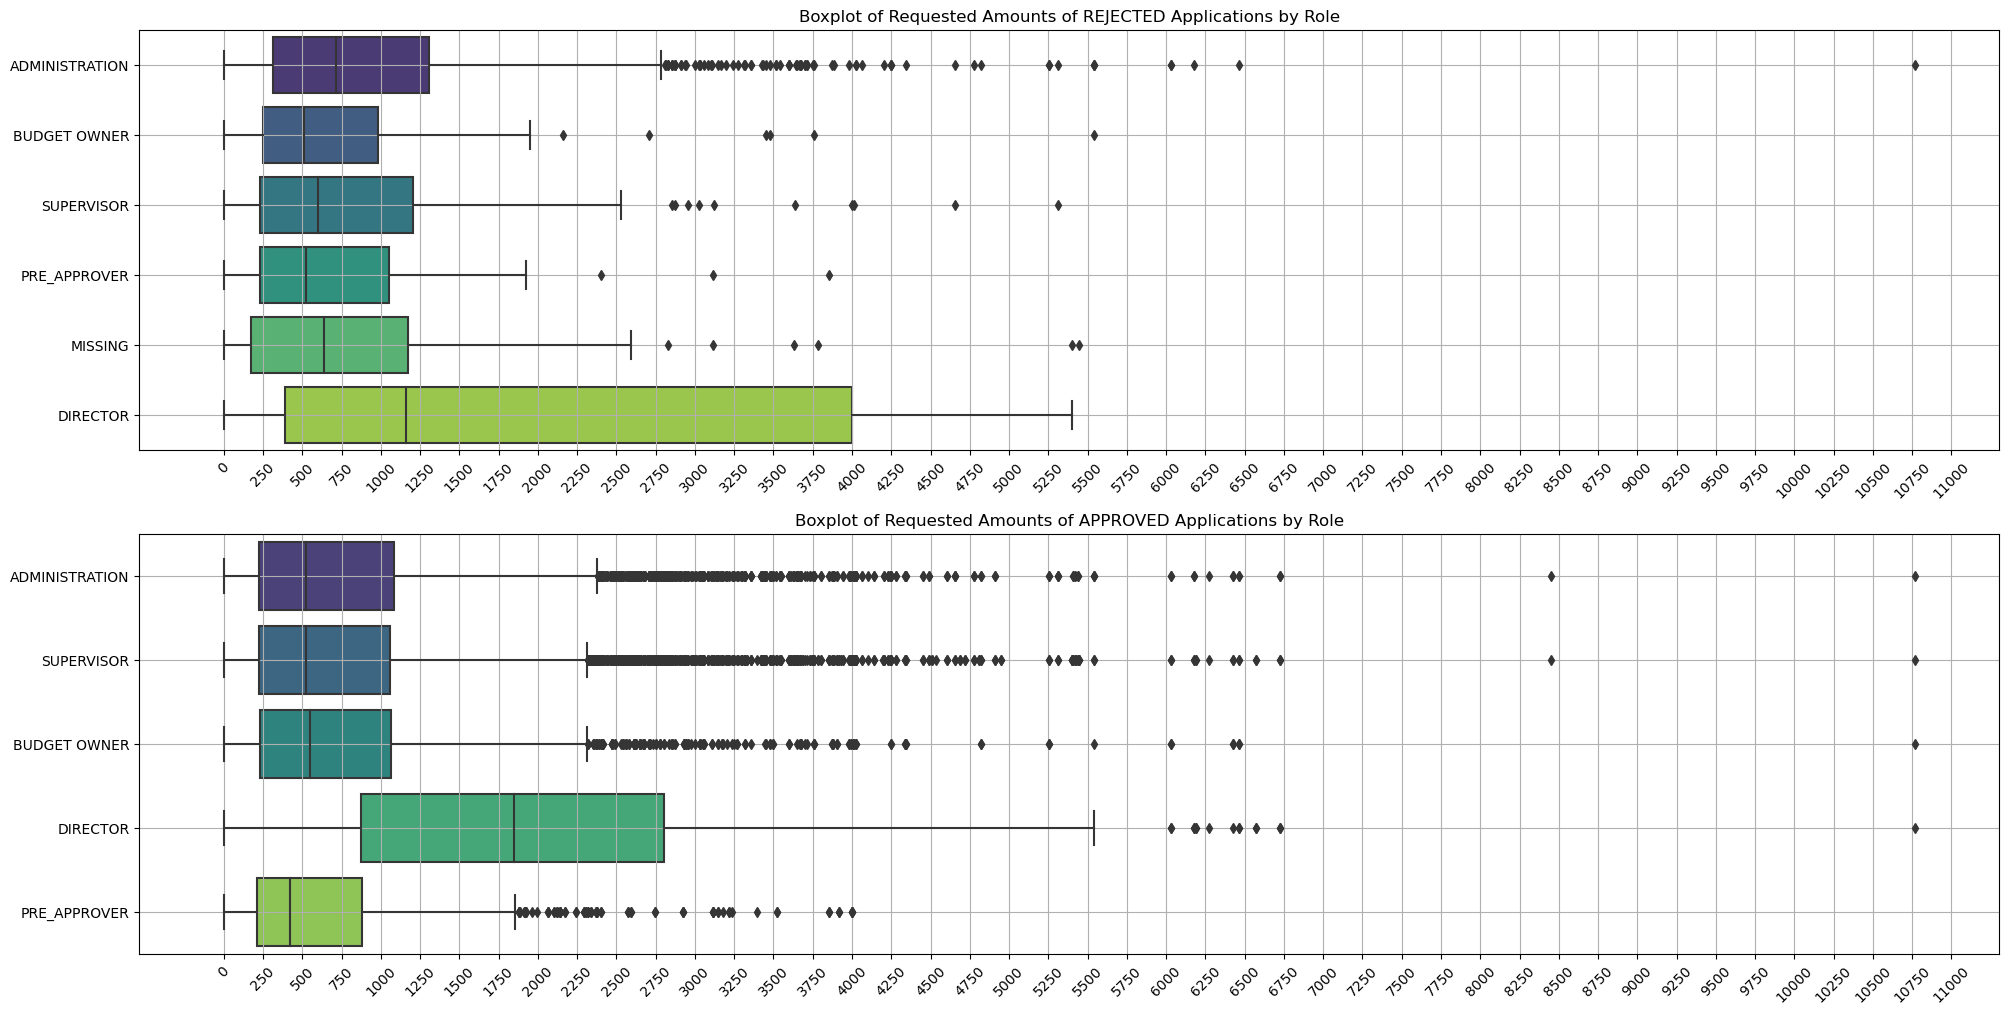

In [110]:
show_boxplot_of_requested_amount_by_role(log_i_r, log_i_a)

We illustrate a boxplot of the requested AMOUNTS of approved and rejected applications. In this case, we consider the dataset of international travel first.

``'ADMINISTRATION'`` role has the highest count of rejected applications at 1632 and has a median requested amount of approximately 700. The range of requested amount varies widely from a minimum of 0 to a significant maximum of approxemately 10750.
The ``'DIRECTOR'`` role has the highest median requested amount of approximately 1150, even though it has the least number of rejections (only 5). This suggests that while fewer requests by the ``'DIRECTOR'`` role get rejected, when they do, it's often for higher amounts.
The ``'MISSING'`` role sees an median rejection amount of about 625, with a notable maximum request of around 5400. Additionally, it is notable that the MISSING role is only involved in the rejection process.

Regarding the accepted applications, ``'ADMINISTRATION'``, ``'SUPERVISOR'`` and ``'BUDGET OWNER'`` have a similar distribution. This may be due to a succession of activities in the process. To this end, another clue could be the outliers at around 8450 and 10800. The ``'DIRECTOR'`` role has a high median accepted amount of around 1850, which is in line with the earlier observation that requests from the ``'DIRECTOR'`` role tend to be of higher monetary value.

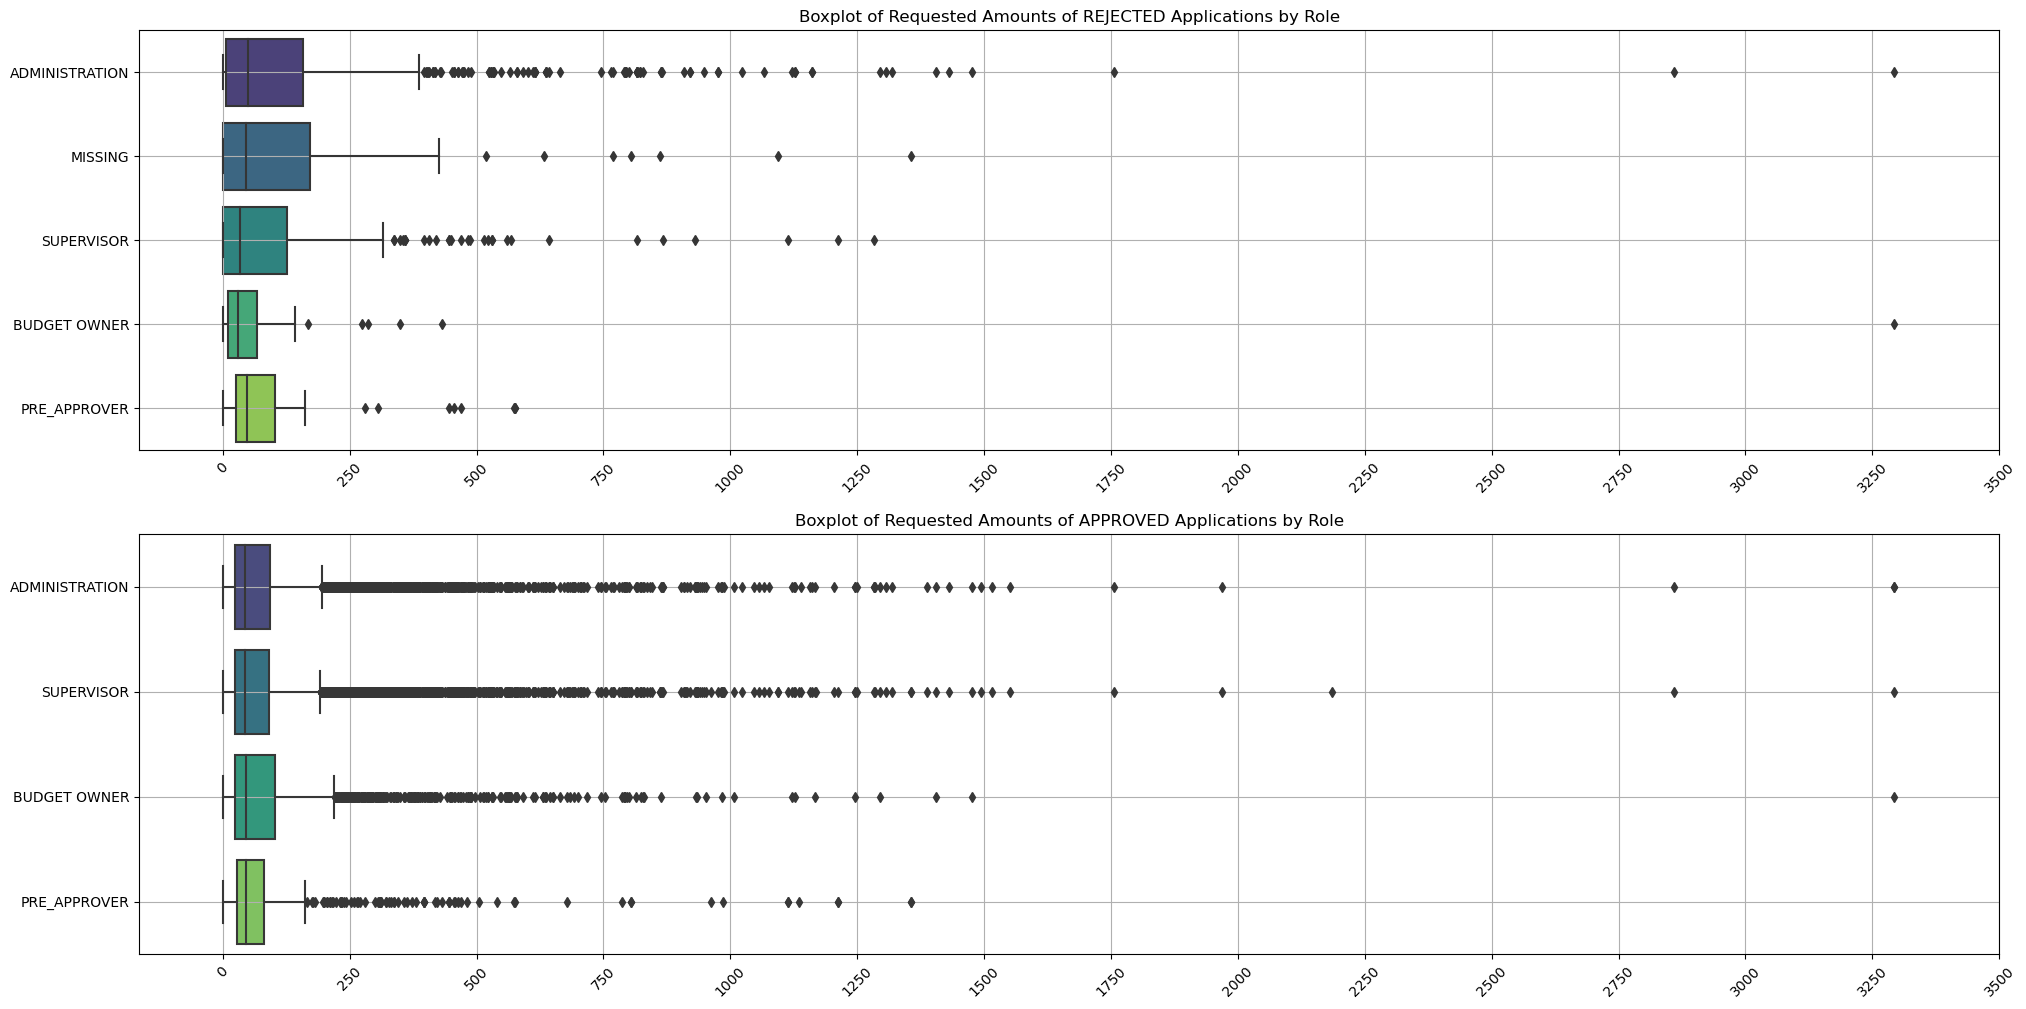

In [111]:
show_boxplot_of_requested_amount_by_role(log_d_r, log_d_a)

Now to the illustration of the domestic travel. 
The ``'ADMINISTRATION'`` role sees the highest number of rejections at 952 applications. The median requested amount is approximately 50, but the data ranges quite widely, with a maximum of around 3300, suggesting there are some large-value requests under this role that get rejected.

Simmilarly, the ``'ADMINISTRATION'`` role sees a median approved amount of around 50, and the samme maximum amountting to 3300. This datapoint might be another hint of the succession of activities in the process, because outliers of the same amount occur for the roles ``'SUPERVISOR'`` and ``'BUDGET OWNER'`` as well.

Generellay, regarding domestic travel, as seen from the quartiles that indicates a right-skewed pattern, a majority of the requests are of lower value.

In [112]:
log_i_paid = log_i[log_i['concept:name'].str.contains('Payment Handled')]  # Contains all approved declarations
log_d_paid = log_d[log_d['concept:name'].str.contains('Payment Handled')]  # Contains all approved declarations

In [113]:
def show_hist_of_requested_amounts(approved_amounts,rejected_amounts):

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)

    sns.histplot(approved_amounts['case:Amount'],color='green', kde=False, bins=50).set(title='Distribution of Requested Amounts for Approved Cases', xlabel='Requested Amount', ylabel='Frequency');
    plt.grid(True)

    plt.subplot(1, 2, 2)
    sns.histplot(rejected_amounts['case:Amount'],color='red', kde=False, bins=50).set(title='Distribution of Requested Amounts for Rejected Cases', xlabel='Requested Amount', ylabel='Frequency');
    plt.grid(True)

    plt.tight_layout()
    plt.show()

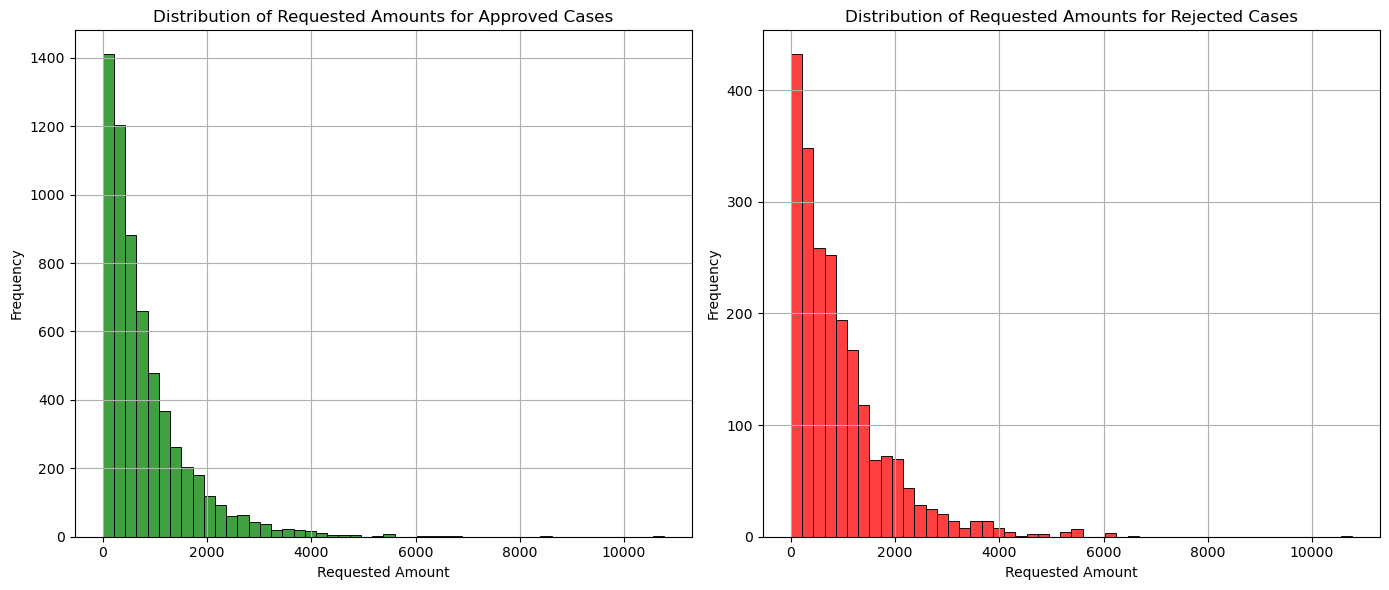

In [114]:
show_hist_of_requested_amounts(log_i_paid, log_i_r)

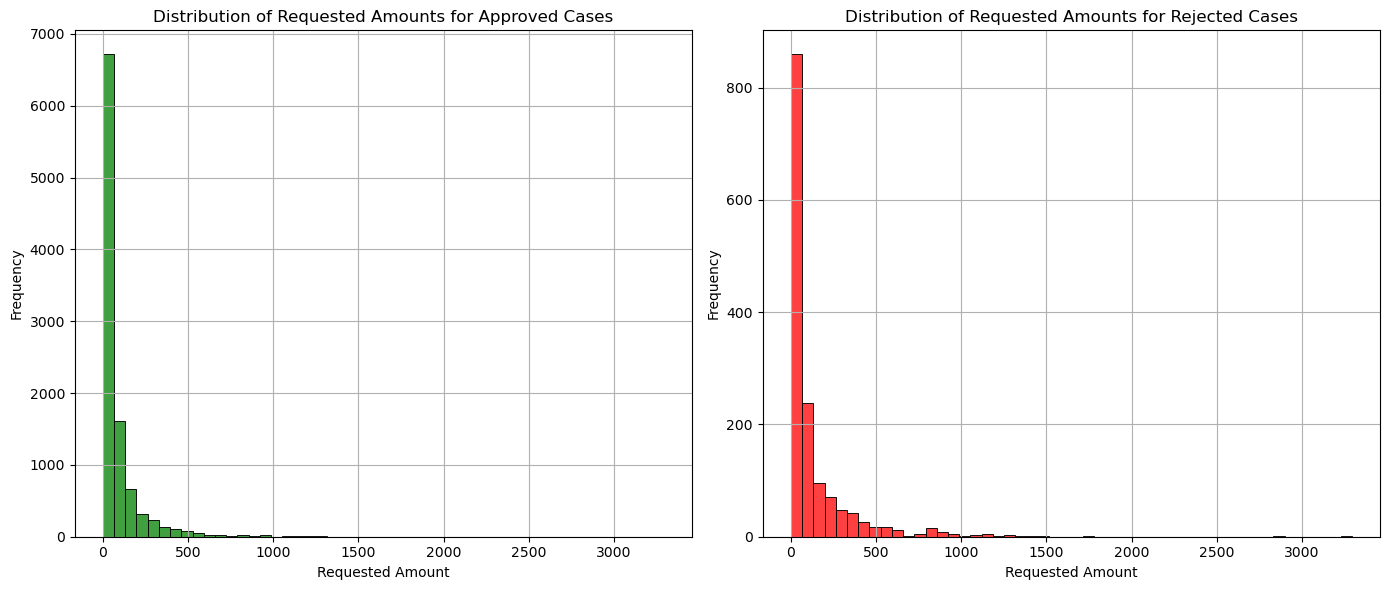

In [115]:
show_hist_of_requested_amounts(log_d_paid, log_d_r)

In both histrogrammes it can be seen that the amount requested will not be a direct indication of an accepted or rejected application.
However, it can be seen that approved and likewise rejected cases of international travel are more likely to be associated with higher requested amounts than domestric travel.

## Are there any patterns that would suggest non-conformance?
- TBD

## Social Network / Handover Network
- TBD

---
## What is missing to provide more detailed insights into the processes?
- TBD

## Reflect on where supervised / unsupervised machine learning techniques could help to obtain further insights.
- TBD

## Can you think of useful KPIs for the processes?
- TBD

## Make specific recommendations for improving the processes.
- TBD

---
# Conclusion